# Sentiment Analysis of IMDB Movie Reviews

This notebook performs sentiment analysis on the IMDB movie review dataset.

**Includes:**
- Data Loading and Exploration
- Text Preprocessing
- Training and Evaluation of:
  - Multinomial Naive Bayes
  - Logistic Regression
  - LSTM (TensorFlow/Keras)
- Model Evaluation and Comparison

In [1]:
import torch

print(torch.cuda.is_available())  # Should return True if GPU is accessible
print(torch.cuda.get_device_name(0))  # Name of the GPU


True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


## 1. Data Loading and Exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

print("Loading dataset...")
start_time = datetime.now()
df = pd.read_csv('IMDB Dataset.csv')
load_time = datetime.now() - start_time

print(f"Dataset loaded in {load_time.total_seconds():.2f} seconds")
print(f"Dataset shape: {df.shape} (rows, columns)")
print("\nDataset info:")
df.info()

print("\nFirst 5 examples:")
display(df.head())

print("\nSummary statistics:")
display(df.describe(include='all'))


Loading dataset...
Dataset loaded in 0.52 seconds
Dataset shape: (50000, 2) (rows, columns)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

First 5 examples:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Summary statistics:


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [3]:

# Check for missing values and basic stats
print("Missing values:")
print(df.isnull().sum())
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())


Missing values:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


C:\Users\abdul\AppData\Local\Temp\ipykernel_21876\474727509.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', ax=axes[0], palette='viridis')


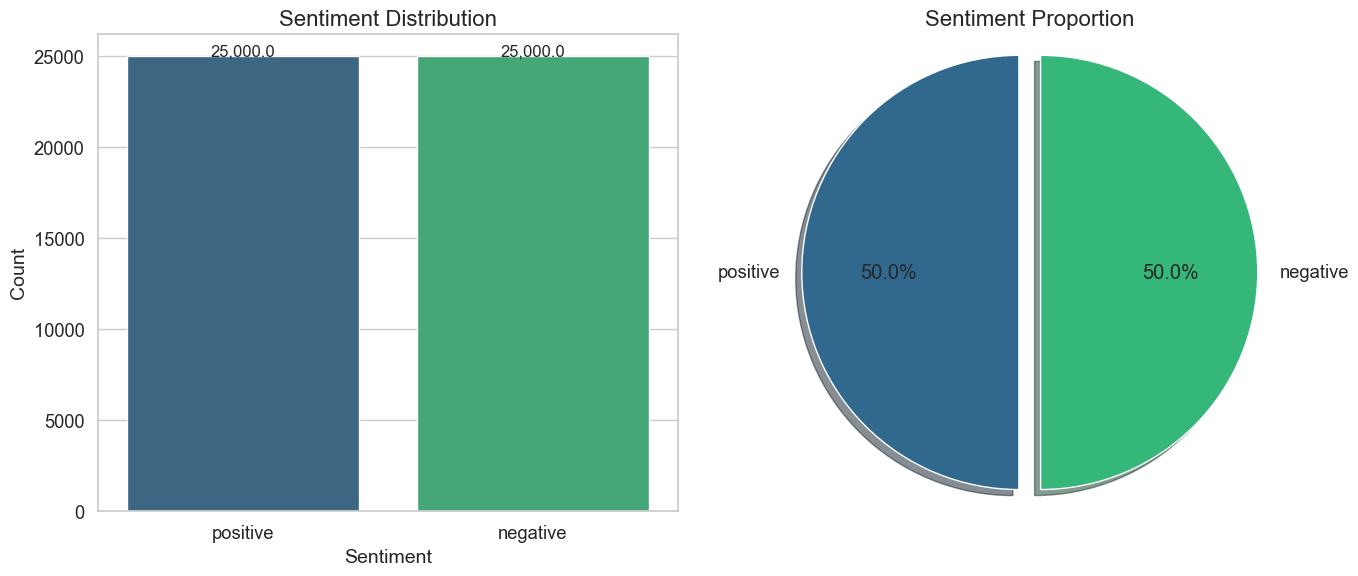


Sentiment counts:


,Sentiment,Count,Percentage
0,positive,25000,50.0
1,negative,25000,50.0


In [4]:
# Enhanced Sentiment Distribution Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Simple countplot
sns.countplot(data=df, x='sentiment', ax=axes[0], palette='viridis')
axes[0].set_title("Sentiment Distribution", fontsize=16)
axes[0].set_xlabel("Sentiment", fontsize=14)
axes[0].set_ylabel("Count", fontsize=14)

# Add count labels on bars
for p in axes[0].patches:
    height = p.get_height()
    axes[0].text(p.get_x() + p.get_width()/2.,
                height + 50,
                f'{height:,}',
                ha="center", fontsize=12)

# Plot 2: Pie chart
sizes = df['sentiment'].value_counts()
labels = sizes.index
explode = (0.05, 0.05)  # explode the slices for visibility

axes[1].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90, colors=sns.color_palette('viridis', 2))
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
axes[1].set_title("Sentiment Proportion", fontsize=16)

plt.tight_layout()
plt.show()

print(f"\nSentiment counts:")
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
sentiment_counts['Percentage'] = sentiment_counts['Count'] / sentiment_counts['Count'].sum() * 100
display(sentiment_counts)


Review length statistics (characters):


count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


Word count statistics:


count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: word_count, dtype: float64


Sentence count statistics:


count    50000.000000
mean        14.010400
std          9.890968
min          1.000000
25%          8.000000
50%         11.000000
75%         17.000000
max        176.000000
Name: sentence_count, dtype: float64

C:\Users\abdul\AppData\Local\Temp\ipykernel_21876\4130779586.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=df, ax=axes[1, 0], palette="viridis")
C:\Users\abdul\AppData\Local\Temp\ipykernel_21876\4130779586.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='word_count', data=df, ax=axes[1, 1], palette="viridis")


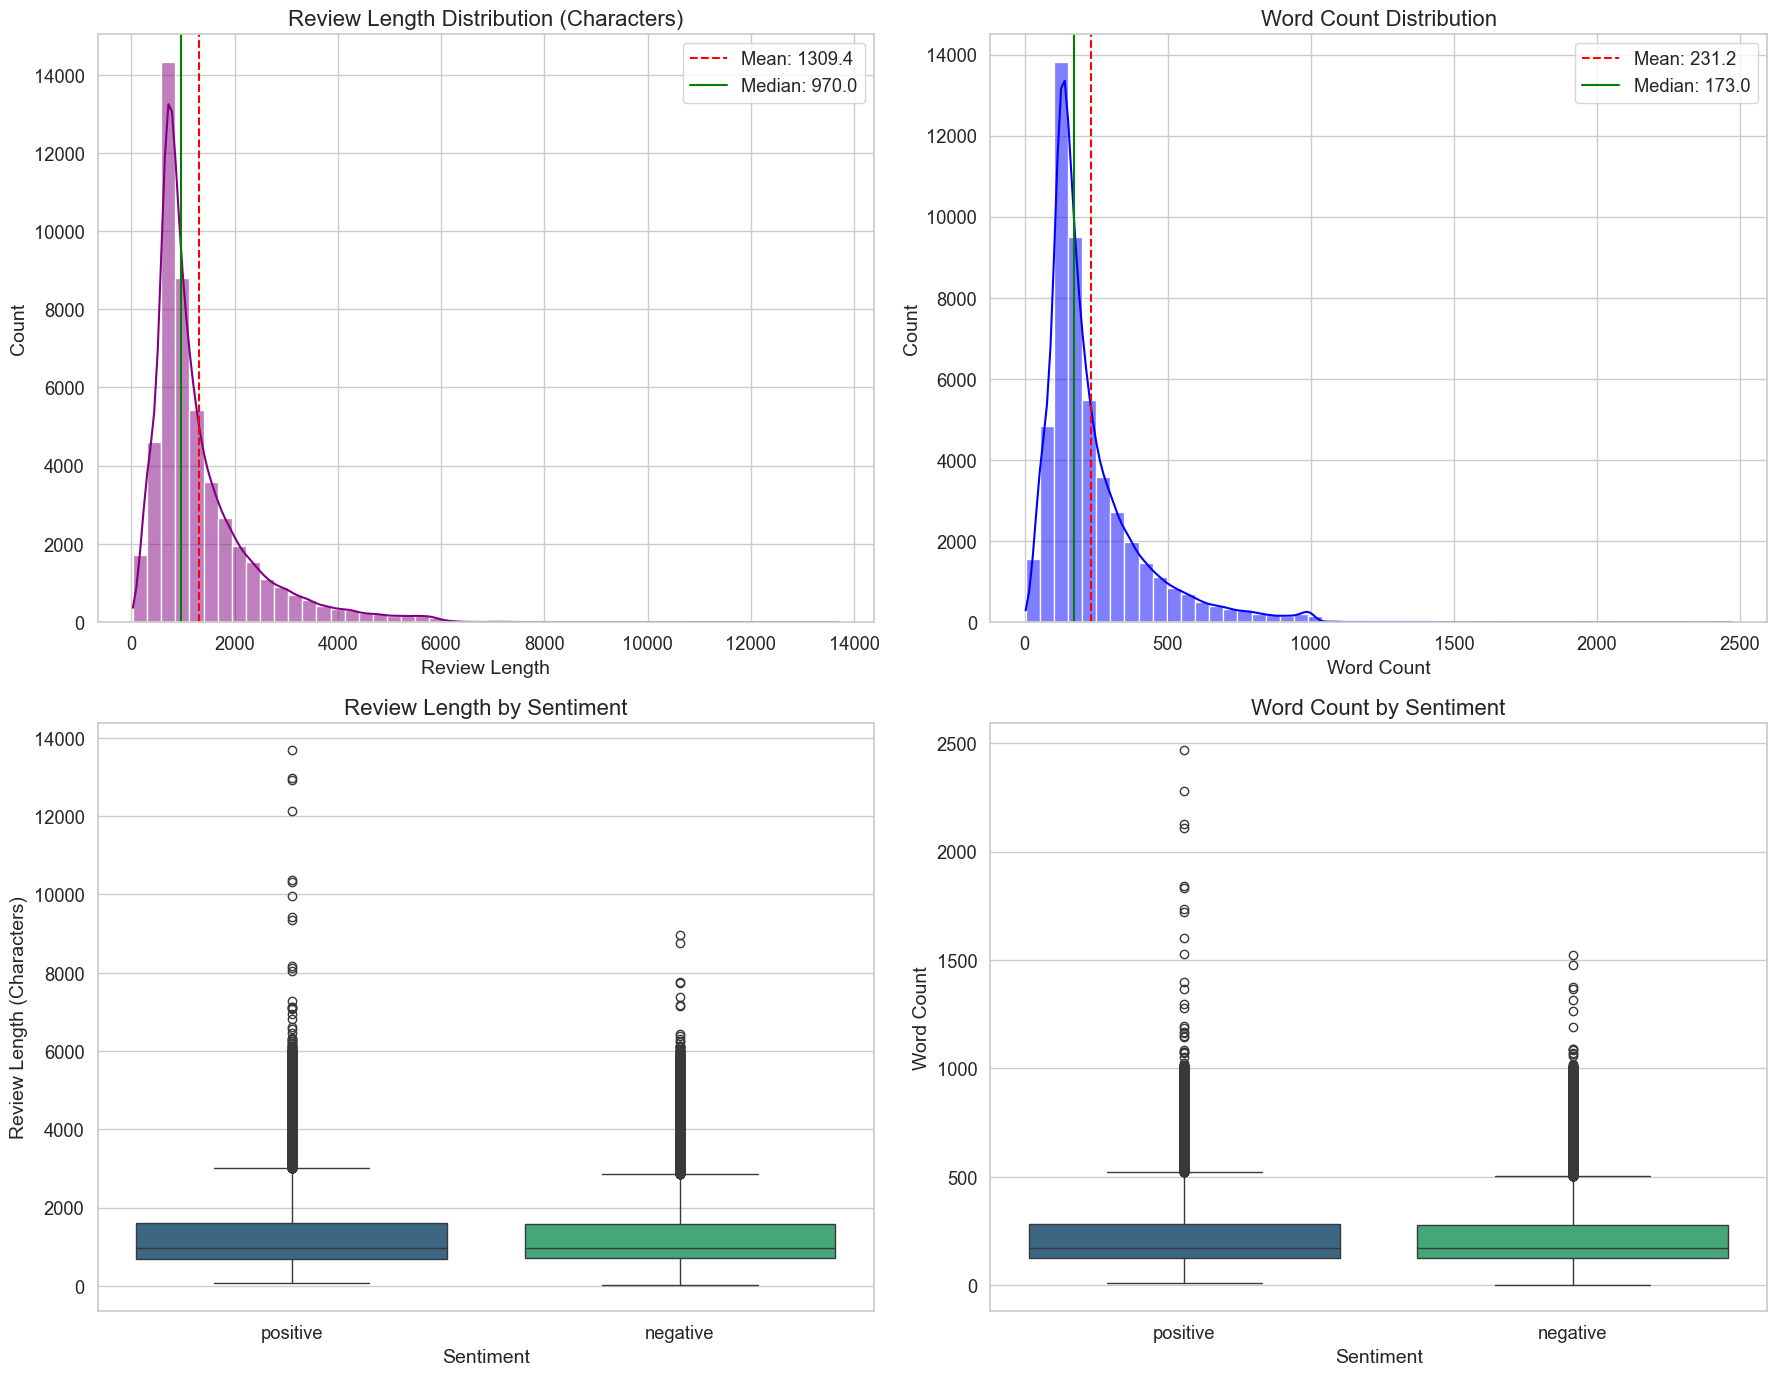


Statistical comparison of review lengths between sentiment groups:
Average review length for negative reviews: 1294.06 characters
Average review length for positive reviews: 1324.80 characters
Difference: 30.73 characters
T-test p-value: 0.000517 (Statistically significant)


In [5]:
# Enhanced Review Length Analysis

df['review_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['review'].apply(lambda x: len(x.split('.')))

print("Review length statistics (characters):")
display(df['review_length'].describe())

print("\nWord count statistics:")
display(df['word_count'].describe())

print("\nSentence count statistics:")
display(df['sentence_count'].describe())

# Create figure with multiple plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Review length distribution
sns.histplot(df['review_length'], bins=50, kde=True, ax=axes[0, 0], color='purple')
axes[0, 0].set_title("Review Length Distribution (Characters)", fontsize=16)
axes[0, 0].set_xlabel("Review Length", fontsize=14)
axes[0, 0].set_ylabel("Count", fontsize=14)
axes[0, 0].axvline(df['review_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['review_length'].mean():.1f}")
axes[0, 0].axvline(df['review_length'].median(), color='green', linestyle='-', label=f"Median: {df['review_length'].median():.1f}")
axes[0, 0].legend()

# Plot 2: Word count distribution
sns.histplot(df['word_count'], bins=50, kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title("Word Count Distribution", fontsize=16)
axes[0, 1].set_xlabel("Word Count", fontsize=14)
axes[0, 1].set_ylabel("Count", fontsize=14)
axes[0, 1].axvline(df['word_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['word_count'].mean():.1f}")
axes[0, 1].axvline(df['word_count'].median(), color='green', linestyle='-', label=f"Median: {df['word_count'].median():.1f}")
axes[0, 1].legend()

# Plot 3: Boxplot comparison by sentiment
sns.boxplot(x='sentiment', y='review_length', data=df, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Review Length by Sentiment", fontsize=16)
axes[1, 0].set_xlabel("Sentiment", fontsize=14)
axes[1, 0].set_ylabel("Review Length (Characters)", fontsize=14)

# Plot 4: Word count by sentiment
sns.boxplot(x='sentiment', y='word_count', data=df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title("Word Count by Sentiment", fontsize=16)
axes[1, 1].set_xlabel("Sentiment", fontsize=14)
axes[1, 1].set_ylabel("Word Count", fontsize=14)

plt.tight_layout()
plt.show()

# Statistical comparison between sentiment groups
print("\nStatistical comparison of review lengths between sentiment groups:")
negative_reviews = df[df['sentiment'] == 'negative']['review_length']
positive_reviews = df[df['sentiment'] == 'positive']['review_length']

print(f"Average review length for negative reviews: {negative_reviews.mean():.2f} characters")
print(f"Average review length for positive reviews: {positive_reviews.mean():.2f} characters")
print(f"Difference: {abs(negative_reviews.mean() - positive_reviews.mean()):.2f} characters")

from scipy import stats
t_stat, p_value = stats.ttest_ind(negative_reviews, positive_reviews, equal_var=False)
print(f"T-test p-value: {p_value:.6f} ({'Statistically significant' if p_value < 0.05 else 'Not statistically significant'})")


## 2. Text Preprocessing and Feature Analysis

In this section, we:
1. Clean the text by removing HTML tags, punctuation, converting to lowercase
2. Remove stopwords and perform lemmatization for better feature extraction
3. Analyze the most frequent words and their impact on sentiment
4. Visualize key textual features that differentiate positive and negative reviews

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abdul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✓ wordnet downloaded
✓ stopwords downloaded
✓ punkt already downloaded
Preprocessing reviews...

Sample of original vs. cleaned reviews:


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...


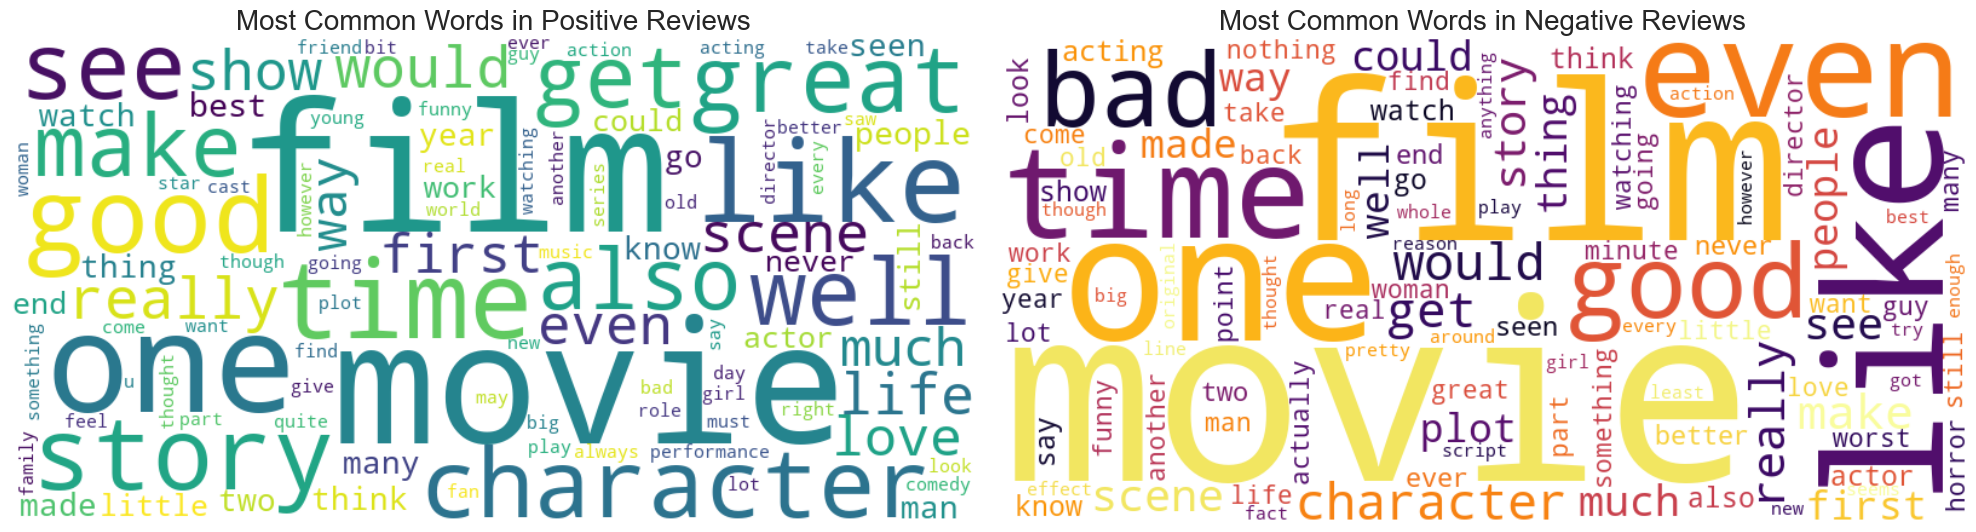

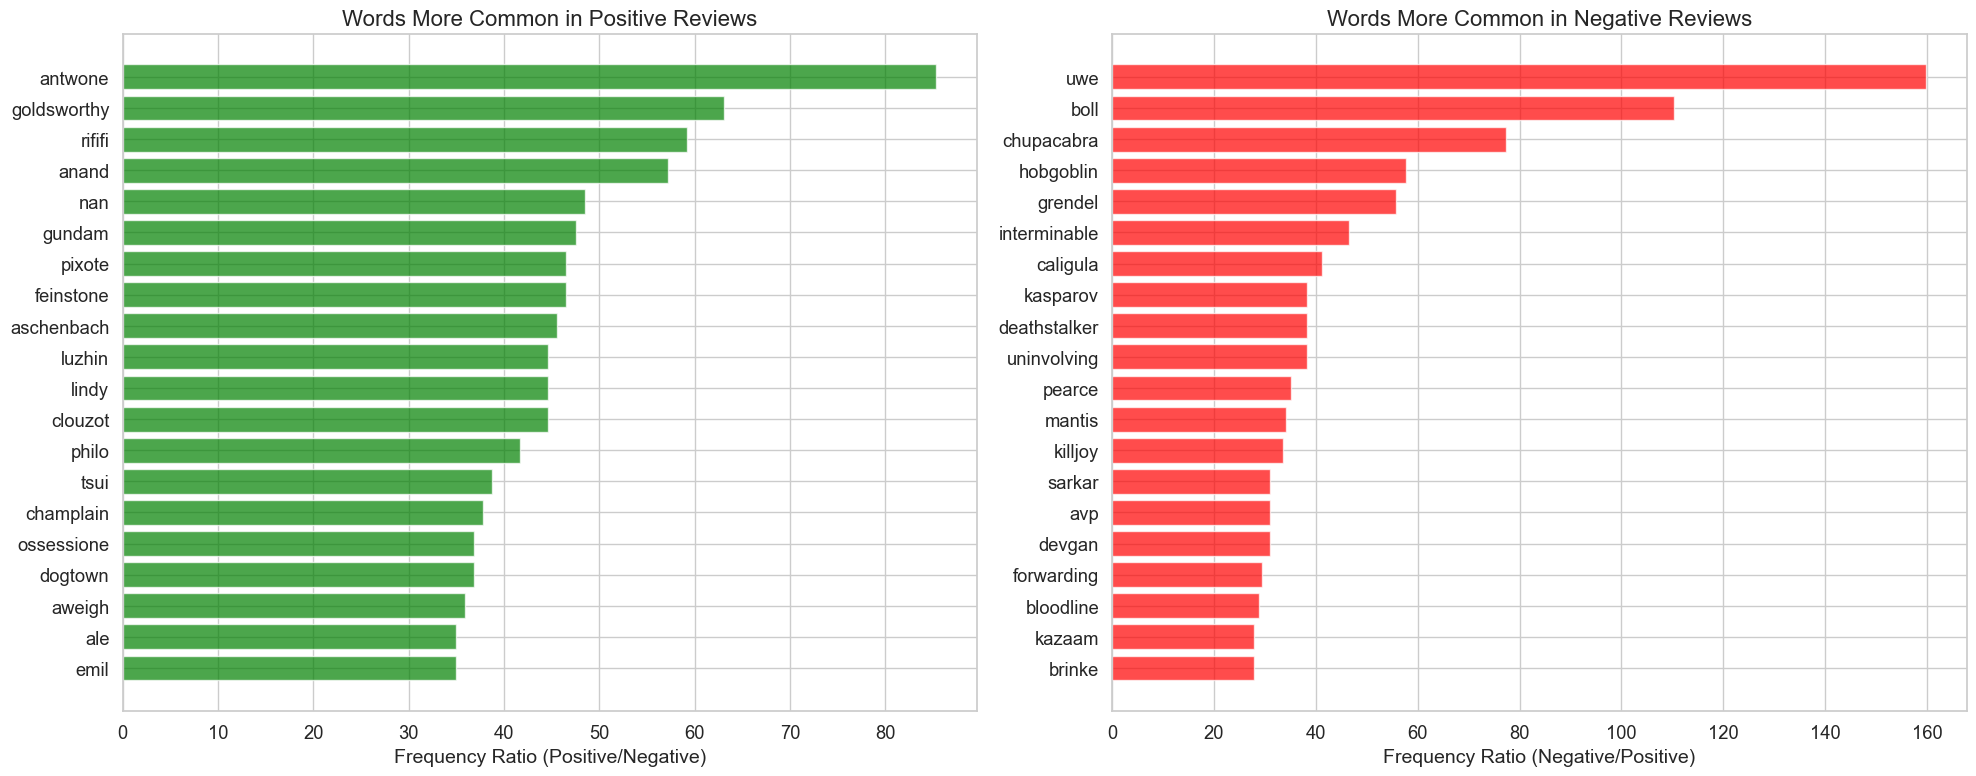


Text Preprocessing Statistics:
Average original review length: 1309.43 characters
Average cleaned review length: 799.98 characters
Average text reduction: 39.30%
Total vocabulary size after preprocessing: 91,788 unique words


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

# Download NLTK resources if not already present
print("Downloading necessary NLTK resources...")
for resource in ['wordnet', 'stopwords', 'punkt']:
    try:
        nltk.data.find(f'tokenizers/{resource}')
        print(f"✓ {resource} already downloaded")
    except LookupError:
        nltk.download(resource)
        print(f"✓ {resource} downloaded")

# Define a set of stopwords
stop_words = set(stopwords.words('english'))

# Create a lemmatizer
lemmatizer = WordNetLemmatizer()

# Define text preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<.*?>', '', text)
    
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 1]
    
    return ' '.join(tokens)

# Apply preprocessing to reviews
print("Preprocessing reviews...")
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Map sentiment labels to binary values
df['sentiment_label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

# Display sample of original vs. cleaned reviews
print("\nSample of original vs. cleaned reviews:")
sample_comparison = df[['review', 'cleaned_review']].head(3)
display(sample_comparison)

# Get word frequencies by sentiment
def get_word_freq(texts):
    all_words = ' '.join(texts).split()
    return Counter(all_words)

positive_words = get_word_freq(df[df['sentiment'] == 'positive']['cleaned_review'])
negative_words = get_word_freq(df[df['sentiment'] == 'negative']['cleaned_review'])

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Positive reviews word cloud
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', 
                              colormap='viridis', max_words=100).generate_from_frequencies(positive_words)
axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Most Common Words in Positive Reviews', fontsize=20)
axes[0].axis('off')

# Negative reviews word cloud
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', 
                              colormap='inferno', max_words=100).generate_from_frequencies(negative_words)
axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Most Common Words in Negative Reviews', fontsize=20)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Feature analysis: Most distinctive words by sentiment
def get_distinctive_words(positive_words, negative_words, top_n=20):
    # Get total word counts
    total_positive = sum(positive_words.values())
    total_negative = sum(negative_words.values())
    
    # Calculate frequency ratio for words that appear in both
    word_ratio = {}
    
    for word in set(positive_words) | set(negative_words):
        pos_freq = positive_words.get(word, 0) / total_positive
        neg_freq = negative_words.get(word, 0) / total_negative
        
        # Avoid division by zero
        if pos_freq > 0 and neg_freq > 0:
            ratio = pos_freq / neg_freq
            word_ratio[word] = ratio
    
    # Get top positive and negative distinctive words
    distinctive_positive = sorted(word_ratio.items(), key=lambda x: x[1], reverse=True)[:top_n]
    distinctive_negative = sorted(word_ratio.items(), key=lambda x: x[1])[:top_n]
    
    return distinctive_positive, distinctive_negative

# Get distinctive words
distinctive_positive, distinctive_negative = get_distinctive_words(positive_words, negative_words)

# Visualize distinctive words
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Distinctive positive words
pos_words = [word for word, ratio in distinctive_positive]
pos_ratios = [ratio for word, ratio in distinctive_positive]

axes[0].barh(pos_words[::-1], pos_ratios[::-1], color='green', alpha=0.7)
axes[0].set_title('Words More Common in Positive Reviews', fontsize=16)
axes[0].set_xlabel('Frequency Ratio (Positive/Negative)', fontsize=14)

# Distinctive negative words
neg_words = [word for word, ratio in distinctive_negative]
neg_ratios = [1/ratio for word, ratio in distinctive_negative]  # Invert ratio for visualization

axes[1].barh(neg_words[::-1], neg_ratios[::-1], color='red', alpha=0.7)
axes[1].set_title('Words More Common in Negative Reviews', fontsize=16)
axes[1].set_xlabel('Frequency Ratio (Negative/Positive)', fontsize=14)

plt.tight_layout()
plt.show()

# Calculate and display preprocessing statistics
print("\nText Preprocessing Statistics:")
original_lengths = df['review'].apply(len)
cleaned_lengths = df['cleaned_review'].apply(len)
reduction_pct = ((original_lengths - cleaned_lengths) / original_lengths * 100)

print(f"Average original review length: {original_lengths.mean():.2f} characters")
print(f"Average cleaned review length: {cleaned_lengths.mean():.2f} characters")
print(f"Average text reduction: {reduction_pct.mean():.2f}%")

# Calculate vocabulary size
vocabulary = set(' '.join(df['cleaned_review']).split())
print(f"Total vocabulary size after preprocessing: {len(vocabulary):,} unique words")


## 3. Splitting Data and TF-IDF Feature Extraction

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['cleaned_review']
y = df['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [8]:

import transformers
print(f"Transformers version: {transformers.__version__}")
import datasets
print(f"Datasets version: {datasets.__version__}")
import accelerate
print(f"Accelerate version: {accelerate.__version__}")

Transformers version: 4.51.3
Datasets version: 3.6.0
Accelerate version: 1.7.0


## 4. Training Traditional Machine Learning Models

Logistic Regression Results:
Training Accuracy: 0.9230
Test Accuracy: 0.8953

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



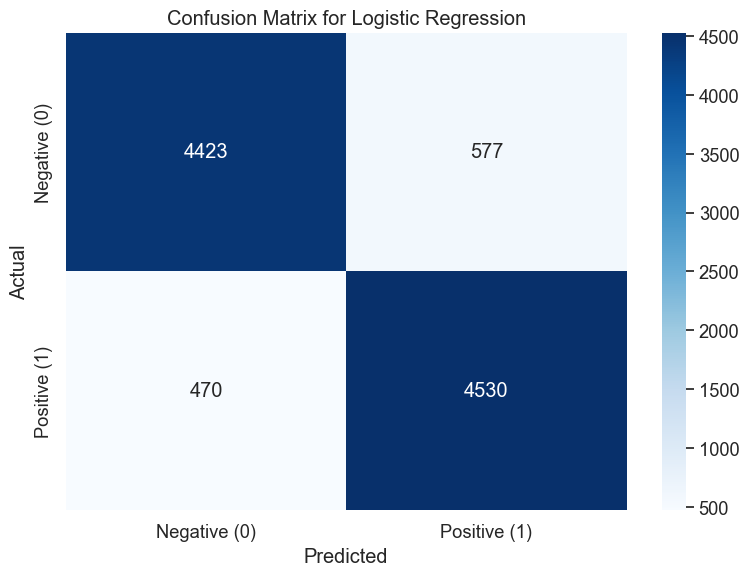


Performing 3-fold cross-validation:
Cross-validation scores: [0.89170541 0.88629716 0.88854721]
Mean CV accuracy: 0.8888
Standard deviation: 0.0022


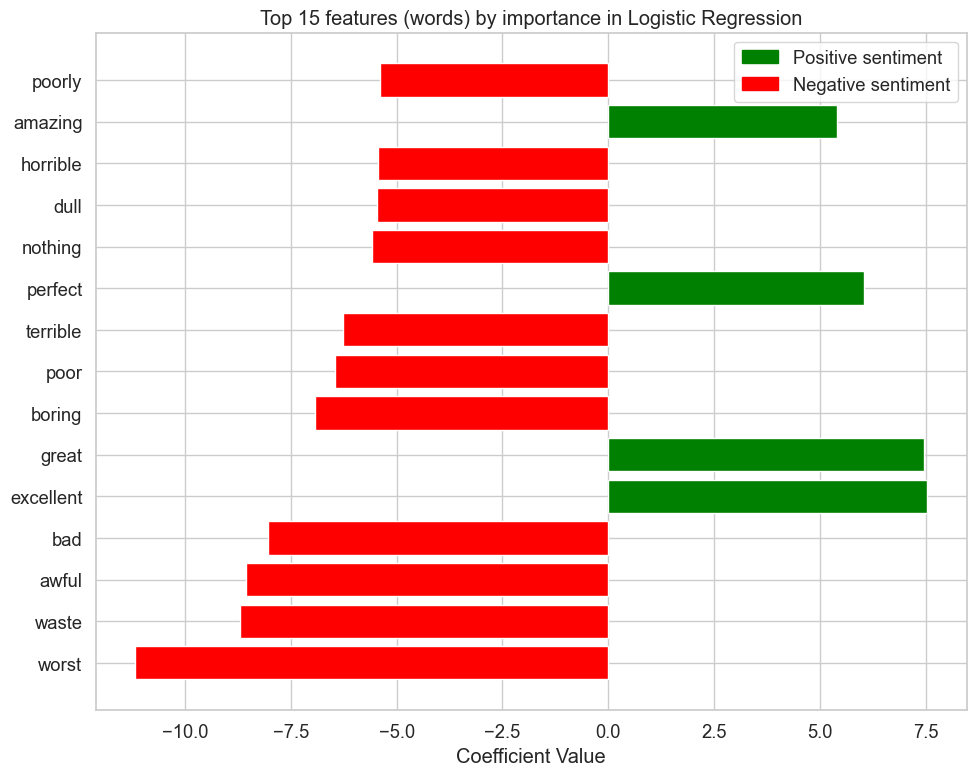

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize and train the logistic regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on training and test sets
y_train_pred = lr_model.predict(X_train_tfidf)
y_test_pred = lr_model.predict(X_test_tfidf)

# Calculate accuracy for both sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Logistic Regression Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detailed classification report for test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Create confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (0)', 'Positive (1)'],
            yticklabels=['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.tight_layout()
plt.show()

# 3-fold cross-validation
print("\nPerforming 3-fold cross-validation:")
cv_scores = cross_val_score(lr_model, X_train_tfidf, y_train, cv=3, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")

# Feature importance visualization (top coefficients by magnitude)
n_features = 15
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Sort coefficients by absolute value (most important first)
coef_abs = np.abs(lr_model.coef_[0])
top_indices = coef_abs.argsort()[-n_features:][::-1]
top_features = feature_names[top_indices]
top_coef = lr_model.coef_[0][top_indices]

# Split into positive and negative coefficients
pos_indices = top_coef > 0
neg_indices = ~pos_indices

# Create a bar plot showing the top features
plt.figure(figsize=(10, 8))
bars = plt.barh(
    np.arange(n_features), 
    top_coef, 
    color=['green' if c > 0 else 'red' for c in top_coef]
)
plt.yticks(np.arange(n_features), top_features)
plt.xlabel('Coefficient Value')
plt.title(f'Top {n_features} features (words) by importance in Logistic Regression')

# Add labels to indicate positive (predictive of positive sentiment) and negative
plt.legend([plt.Rectangle((0,0),1,1,color='green'), plt.Rectangle((0,0),1,1,color='red')],
           ['Positive sentiment', 'Negative sentiment'])
plt.tight_layout()
plt.show()


### 4.1 Fine-tuning BERT Model

In [13]:
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch # Added: Import torch, as it's used for tensors and CUDA checks
from torch import nn # This was already correctly imported later, but good to group if needed

# 1. Prepare Data for Hugging Face Datasets
# Assuming X_train, y_train, X_test, y_test are available
# Dummy data for self-contained example:
# X_train = ["This is a positive example"] * 80 + ["This is a negative example"] * 20
# y_train = [1] * 80 + [0] * 20
# X_test = ["Another positive test example"] * 10 + ["Another negative test example"] * 10
# y_test = [1] * 10 + [0] * 10
# Ensure X_train, y_train, X_test, y_test are actually loaded from cell 25749f5e in your environment

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# 2. Load Tokenizer and Tokenize Data
tokenizer_bert = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function_bert(examples):
    return tokenizer_bert(examples['text'], padding='max_length', truncation=True, max_length=256)

train_dataset_tokenized = train_dataset.map(tokenize_function_bert, batched=True)
test_dataset_tokenized = test_dataset.map(tokenize_function_bert, batched=True)

# 3. Load BERT Model
# Check for class imbalance and calculate class weights if needed BEFORE converting to torch format

# --- Start of corrected section ---
# Access the 'label' column, which returns a list of labels from the Hugging Face Dataset
labels_list_train = train_dataset_tokenized['label']

# Convert the list to a pandas Series to use value_counts()
# Then, sort_index() to ensure class counts are ordered by label (e.g., label 0, then label 1)
class_counts_series = pd.Series(labels_list_train).value_counts().sort_index()
class_counts = class_counts_series.to_list()

# num_classes is the number of unique labels found in the training data
num_classes = len(class_counts)
total_samples = sum(class_counts) # This is equivalent to len(labels_list_train)
# --- End of corrected section ---


# Remove original text column, set format for PyTorch after checking class balance
train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
train_dataset_tokenized.set_format("torch")
test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text"])
test_dataset_tokenized.set_format("torch")

# The model expects a specific number of labels, typically 2 for binary classification.
# The class weighting logic is applied if num_classes (derived from data) matches this expectation (e.g., 2)
# AND there's significant imbalance.
EXPECTED_NUM_LABELS_FOR_MODEL = 2 # Based on num_labels=2 for BertForSequenceClassification later

should_use_custom_trainer = False # Default
if num_classes == EXPECTED_NUM_LABELS_FOR_MODEL: # Ensure data matches model's expectation for weighting
    # Check for significant imbalance (e.g., minority class is less than 40% of data)
    # Ensure total_samples > 0 to avoid division by zero if dataset is empty
    if total_samples > 0 and min(class_counts) / total_samples < 0.4:
        print(f"Class imbalance detected. Class distribution: {[count/total_samples for count in class_counts]}")
        # Calculate class weights (inverse frequency)
        # Ensure no division by zero if a class count is 0 (though min(class_counts) > 0 if this path is taken carefully)
        class_weights = [total_samples / (num_classes * count) if count > 0 else 1.0 for count in class_counts]
        print(f"Using class weights: {class_weights}")

        # Convert to pytorch tensor for the model
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
        if torch.cuda.is_available():
            class_weights_tensor = class_weights_tensor.to('cuda')

        # For BertForSequenceClassification, we need to customize the Trainer to handle class weights
        # This is done by subclassing the Trainer and overriding compute_loss
        # from torch import nn # Already imported at the top or available
        
        class CustomTrainer(Trainer):
            def compute_loss(self, model, inputs, return_outputs=False):
                labels = inputs.pop("labels")
                outputs = model(**inputs)
                logits = outputs.get("logits")
                # Ensure class_weights_tensor is on the same device as logits
                # The number of labels for CrossEntropyLoss should match model's config
                loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
                loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
                return (loss, outputs) if return_outputs else loss
                
        should_use_custom_trainer = True
    else:
        print("Class distribution is balanced or does not meet imbalance criteria. Using standard training approach.")
else:
    print(f"Data has {num_classes} unique labels, but model expects {EXPECTED_NUM_LABELS_FOR_MODEL} for specific class weighting. Using standard training approach.")


# Load the model as usual
bert_model_fine_tuned = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=EXPECTED_NUM_LABELS_FOR_MODEL)

# 4. Define Compute Metrics Function for Trainer
def compute_metrics_bert(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'macro_f1': f1,
        'macro_precision': precision,
        'macro_recall': recall
    }

# 5. Define Training Arguments
training_args_bert = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=3e-5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    logging_dir='./logs_bert',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    report_to="none",
    lr_scheduler_type="cosine",
    fp16=torch.cuda.is_available(),
    tf32=torch.cuda.is_available()
)

# 6. Create Trainer Instance
if should_use_custom_trainer:
    bert_trainer = CustomTrainer(
        model=bert_model_fine_tuned,
        args=training_args_bert,
        train_dataset=train_dataset_tokenized,
        eval_dataset=test_dataset_tokenized,
        compute_metrics=compute_metrics_bert
    )
    print("Using CustomTrainer with class weights for better handling of imbalanced data.")
else:
    bert_trainer = Trainer(
        model=bert_model_fine_tuned,
        args=training_args_bert,
        train_dataset=train_dataset_tokenized,
        eval_dataset=test_dataset_tokenized,
        compute_metrics=compute_metrics_bert
    )
    print("Using standard Trainer.")


# 7. Fine-tune the Model
print("Starting BERT model fine-tuning with improved settings...")
bert_trainer.train()

print("\nBERT model fine-tuning complete.")
print("Evaluating fine-tuned BERT model on the test set (using Trainer's evaluate method):")
bert_eval_results_trainer = bert_trainer.evaluate(test_dataset_tokenized)
for key, value in bert_eval_results_trainer.items():
    print(f"{key}: {value:.4f}")

# Save the best model and tokenizer
save_path = "./results_bert/best_model"
bert_trainer.save_model(save_path)
tokenizer_bert.save_pretrained(save_path)
print(f"\nBest model saved to {save_path}")

# Calculate and print some additional metrics for better understanding model performance
from sklearn.metrics import classification_report

# Get predictions on test set
test_predictions = bert_trainer.predict(test_dataset_tokenized)
y_pred_bert = np.argmax(test_predictions.predictions, axis=1) # Renamed to avoid clash if y_pred exists
y_true_bert = test_predictions.label_ids # Renamed to avoid clash if y_true exists

# Create a detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=[f"Class {i}" for i in range(EXPECTED_NUM_LABELS_FOR_MODEL)]))

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Class distribution is balanced or does not meet imbalance criteria. Using standard training approach.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

C:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abdul\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Using standard Trainer.
Starting BERT model fine-tuning with improved settings...


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Macro Precision,Macro Recall
1,0.314800,0.311568,0.882800,0.882007,0.893380,0.882800
2,0.207800,0.274521,0.908000,0.907928,0.909284,0.908000
3,0.097900,0.343330,0.914900,0.914899,0.914916,0.914900
4,0.030600,0.457777,0.912300,0.912292,0.912455,0.912300
5,0.043300,0.494759,0.914500,0.914497,0.914550,0.914500



BERT model fine-tuning complete.
Evaluating fine-tuned BERT model on the test set (using Trainer's evaluate method):


eval_loss: 0.3433
eval_accuracy: 0.9149
eval_macro_f1: 0.9149
eval_macro_precision: 0.9149
eval_macro_recall: 0.9149
eval_runtime: 43.2191
eval_samples_per_second: 231.3790
eval_steps_per_second: 14.4610
epoch: 5.0000

Best model saved to ./results_bert/best_model

Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.92      0.92      5000
     Class 1       0.92      0.91      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Extracting training metrics from BERT Trainer state for analysis...


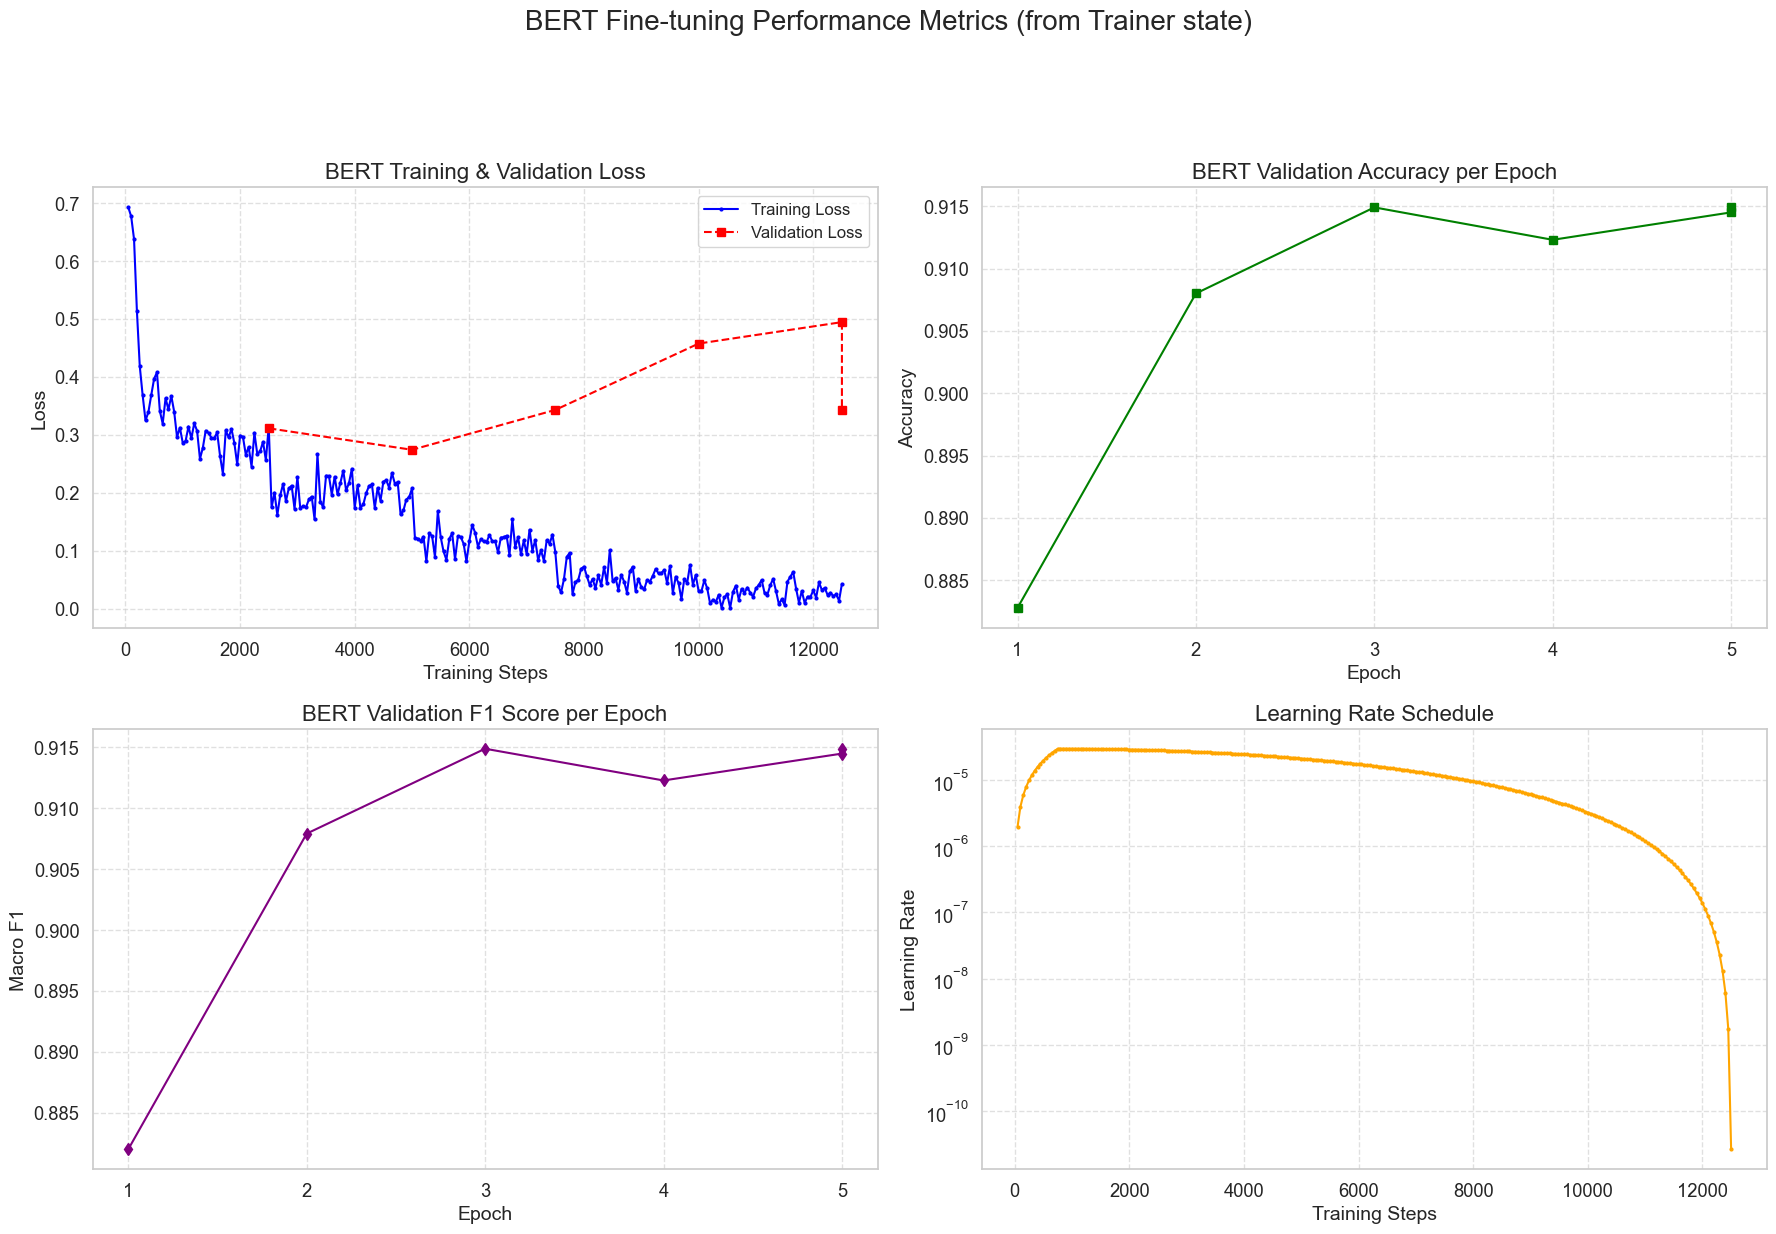


Training Summary Statistics (from Trainer state):
Final training loss: 0.0433 (at step 12500)
Best validation accuracy: 0.9149 (at epoch 3.0)
Best validation F1 score: 0.9149 (at epoch 3.0)

Potential overfitting detected (validation loss increased after reaching a minimum).
Best validation loss: 0.2745 (at epoch 2.0)
Final validation loss: 0.3433 (at epoch 5.0)


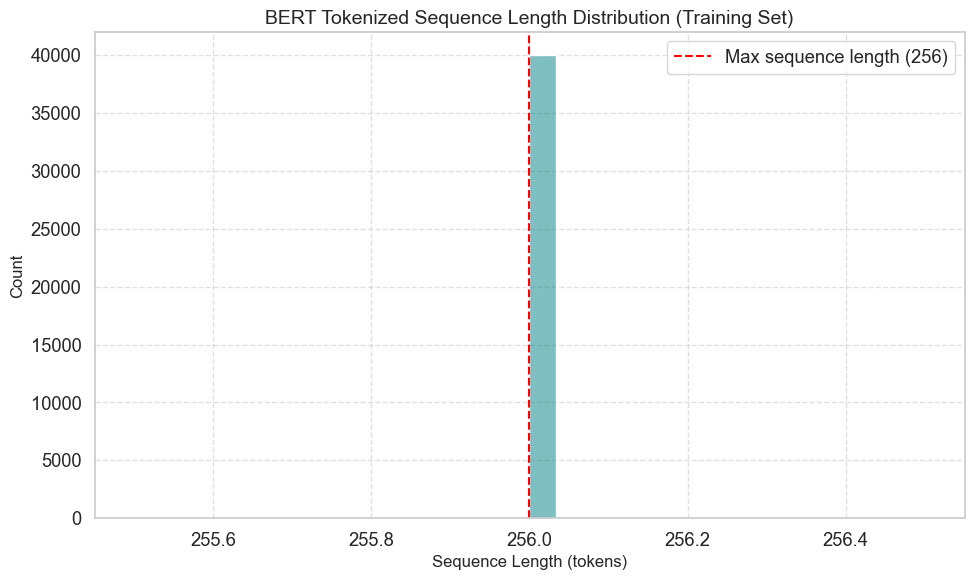

Tokenization Statistics (Training Set):
Average sequence length: 256.00 tokens
Maximum sequence length observed: 256 tokens
Number of sequences at max_length (256): 40000 (100.00%)

Visualizing BERT attention patterns on a sample review (using base BERT model):
Sample review: yes mtv really way market daria started clever teenage angst comment everything suck make viewer feel better sucky teenage life sitcom mutated deal problem charade used watch daria time loved sitting ...


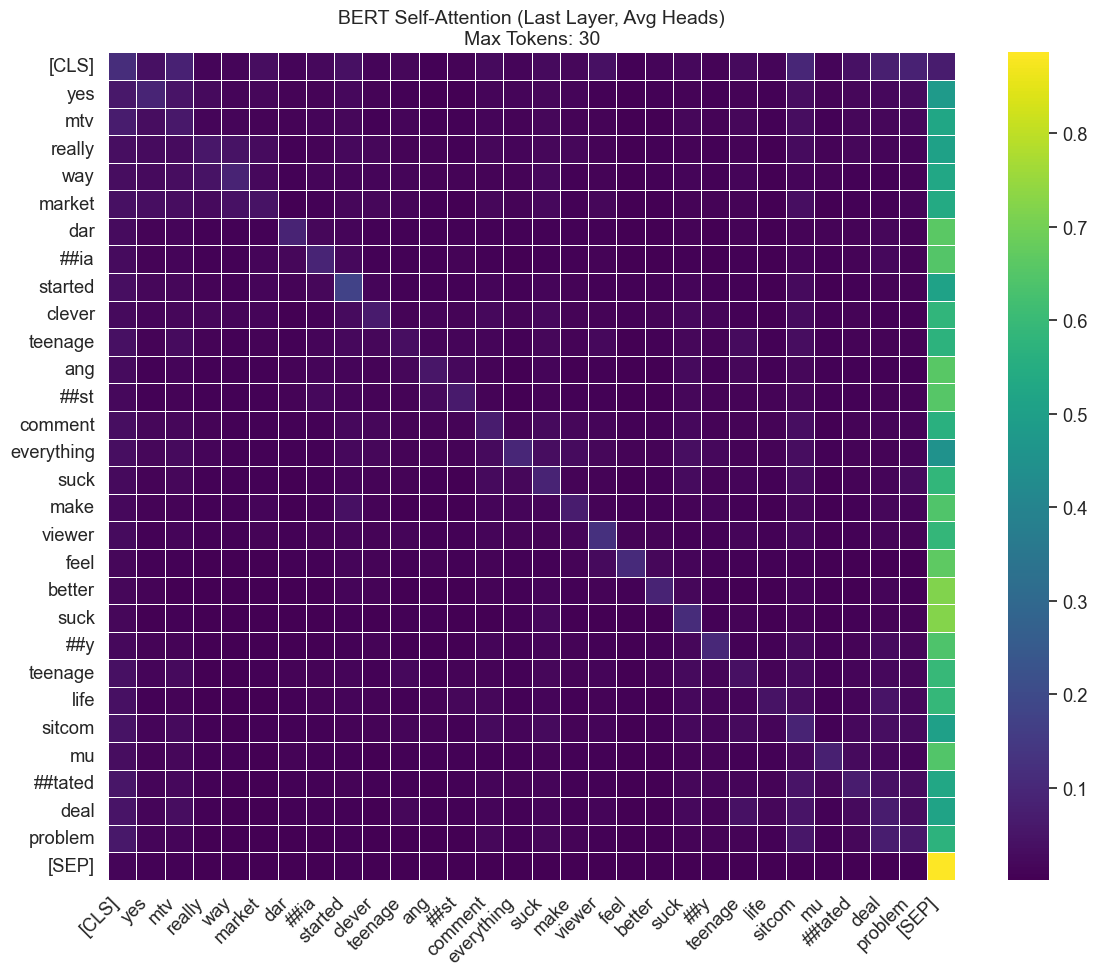

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # For token distribution and attention plots later
# Assuming bert_trainer is the Trainer object from the previous cell after training.
# from transformers import BertTokenizer, BertModel # For attention viz later
# import torch # For attention viz later

# --- Start of Modified Section for Metrics Visualization ---
print("Extracting training metrics from BERT Trainer state for analysis...")

train_log_entries = []
eval_log_entries = []
metrics_available = False

if hasattr(bert_trainer, 'state') and hasattr(bert_trainer.state, 'log_history') and bert_trainer.state.log_history:
    for log_entry in bert_trainer.state.log_history:
        if 'eval_loss' in log_entry: # This indicates an evaluation entry
            eval_log_entries.append(log_entry)
        elif 'loss' in log_entry: # This indicates a training loss entry
            train_log_entries.append(log_entry)
    metrics_available = True
else:
    print("Could not find bert_trainer.state.log_history or it is empty. Cannot visualize training metrics.")

if metrics_available and (train_log_entries or eval_log_entries):
    try:
        # Extract metrics for plotting
        train_losses = [entry['loss'] for entry in train_log_entries if 'loss' in entry]
        train_steps_for_loss = [entry['step'] for entry in train_log_entries if 'step' in entry and 'loss' in entry]
        
        learning_rates = [entry['learning_rate'] for entry in train_log_entries if 'learning_rate' in entry and 'loss' in entry]
        train_steps_for_lr = [entry['step'] for entry in train_log_entries if 'step' in entry and 'learning_rate' in entry and 'loss' in entry]

        eval_losses = [entry['eval_loss'] for entry in eval_log_entries if 'eval_loss' in entry]
        eval_accs = [entry['eval_accuracy'] for entry in eval_log_entries if 'eval_accuracy' in entry]
        eval_f1s = [entry['eval_macro_f1'] for entry in eval_log_entries if 'eval_macro_f1' in entry]
        
        # Use 'step' for x-axis of evaluation loss to align with training loss steps
        eval_steps_for_eval_loss = [entry['step'] for entry in eval_log_entries if 'step' in entry and 'eval_loss' in entry]
        # Use 'epoch' for x-axis of accuracy and F1 scores, as eval_strategy was "epoch"
        eval_epochs_for_metrics = [entry.get('epoch', i + 1.0) for i, entry in enumerate(eval_log_entries)]


        # Plot training metrics with enhanced visuals
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))
        fig.suptitle('BERT Fine-tuning Performance Metrics (from Trainer state)', fontsize=20, y=1.03)

        # Loss plot with train and validation comparison
        if train_losses and train_steps_for_loss:
            axes[0, 0].plot(train_steps_for_loss, train_losses, marker='.', linestyle='-', color='blue', label='Training Loss', markersize=4)
        else:
            axes[0, 0].text(0.5, 0.5, "Training loss data not available.", ha='center', va='center', transform=axes[0,0].transAxes)
            
        if eval_losses and eval_steps_for_eval_loss:
            axes[0, 0].plot(eval_steps_for_eval_loss, eval_losses, marker='s', linestyle='--', color='red', label='Validation Loss')
        elif not train_losses or not train_steps_for_loss: # if no training loss, still mention if no eval loss
             axes[0, 0].text(0.5, 0.4, "Validation loss data not available.", ha='center', va='center', transform=axes[0,0].transAxes)

        axes[0, 0].set_title('BERT Training & Validation Loss', fontsize=16)
        axes[0, 0].set_xlabel('Training Steps', fontsize=14)
        axes[0, 0].set_ylabel('Loss', fontsize=14)
        axes[0, 0].grid(True, linestyle='--', alpha=0.6)
        if (train_losses and train_steps_for_loss) or (eval_losses and eval_steps_for_eval_loss):
            axes[0, 0].legend(fontsize=12)
        
        # Accuracy plot
        if eval_accs and eval_epochs_for_metrics:
            axes[0, 1].plot(eval_epochs_for_metrics, eval_accs, marker='s', linestyle='-', color='green', label='Validation Accuracy')
            axes[0, 1].set_title('BERT Validation Accuracy per Epoch', fontsize=16)
            axes[0, 1].set_xlabel('Epoch', fontsize=14)
            axes[0, 1].set_ylabel('Accuracy', fontsize=14)
            # Ensure x-ticks are sensible for epochs
            if eval_epochs_for_metrics:
                unique_epochs = sorted(list(set(eval_epochs_for_metrics)))
                step = max(1, int(len(unique_epochs) / 10)) if len(unique_epochs) > 1 else 1
                axes[0,1].set_xticks(np.arange(min(unique_epochs), max(unique_epochs)+step, step=step))

        else:
            axes[0, 1].text(0.5, 0.5, "Validation accuracy data not available.", ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0, 1].grid(True, linestyle='--', alpha=0.6)
        
        # F1 plot
        if eval_f1s and eval_epochs_for_metrics:
            axes[1, 0].plot(eval_epochs_for_metrics, eval_f1s, marker='d', linestyle='-', color='purple', label='Validation Macro F1')
            axes[1, 0].set_title('BERT Validation F1 Score per Epoch', fontsize=16)
            axes[1, 0].set_xlabel('Epoch', fontsize=14)
            axes[1, 0].set_ylabel('Macro F1', fontsize=14)
            if eval_epochs_for_metrics:
                unique_epochs = sorted(list(set(eval_epochs_for_metrics)))
                step = max(1, int(len(unique_epochs) / 10)) if len(unique_epochs) > 1 else 1
                axes[1,0].set_xticks(np.arange(min(unique_epochs), max(unique_epochs)+step, step=step))
        else:
            axes[1, 0].text(0.5, 0.5, "Validation F1 score data not available.", ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1, 0].grid(True, linestyle='--', alpha=0.6)
        
        # Learning rate plot
        if learning_rates and train_steps_for_lr:
            axes[1, 1].plot(train_steps_for_lr, learning_rates, marker='.', linestyle='-', color='orange', label='Learning Rate', markersize=4)
            axes[1, 1].set_title('Learning Rate Schedule', fontsize=16)
            axes[1, 1].set_xlabel('Training Steps', fontsize=14)
            axes[1, 1].set_ylabel('Learning Rate', fontsize=14)
            axes[1, 1].set_yscale('log') # Log scale often better for LR
        else:
            axes[1, 1].text(0.5, 0.5, "Learning rate data not available\nor not logged.", 
                      horizontalalignment='center', verticalalignment='center',
                      transform=axes[1, 1].transAxes, fontsize=14)
        axes[1, 1].grid(True, linestyle='--', alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
        plt.show()
        
        # Print summary statistics
        print("\nTraining Summary Statistics (from Trainer state):")
        if train_losses and train_steps_for_loss:
            print(f"Final training loss: {train_losses[-1]:.4f} (at step {train_steps_for_loss[-1]})")
        if eval_accs and eval_epochs_for_metrics:
            best_acc = max(eval_accs)
            best_acc_epoch_idx = eval_accs.index(best_acc)
            # Handle if epoch is float or int for display
            best_acc_epoch_val = eval_epochs_for_metrics[best_acc_epoch_idx]
            print(f"Best validation accuracy: {best_acc:.4f} (at epoch {best_acc_epoch_val:.1f})")
        if eval_f1s and eval_epochs_for_metrics:
            best_f1 = max(eval_f1s)
            best_f1_epoch_idx = eval_f1s.index(best_f1)
            best_f1_epoch_val = eval_epochs_for_metrics[best_f1_epoch_idx]
            print(f"Best validation F1 score: {best_f1:.4f} (at epoch {best_f1_epoch_val:.1f})")
        
        # Check for overfitting (based on validation loss)
        if eval_losses and len(eval_losses) > 1 and eval_epochs_for_metrics:
            min_eval_loss = min(eval_losses)
            min_eval_loss_idx = eval_losses.index(min_eval_loss)
            min_eval_loss_epoch_val = eval_epochs_for_metrics[min_eval_loss_idx]
            
            final_eval_loss = eval_losses[-1]
            final_eval_loss_epoch_val = eval_epochs_for_metrics[-1]

            if final_eval_loss > min_eval_loss: # A simple check
                print("\nPotential overfitting detected (validation loss increased after reaching a minimum).")
                print(f"Best validation loss: {min_eval_loss:.4f} (at epoch {min_eval_loss_epoch_val:.1f})")
                print(f"Final validation loss: {final_eval_loss:.4f} (at epoch {final_eval_loss_epoch_val:.1f})")
            else:
                print("\nNo clear signs of overfitting based on validation loss progression.")
                print(f"Minimum validation loss: {min_eval_loss:.4f} (at epoch {min_eval_loss_epoch_val:.1f})")
                print(f"Final validation loss: {final_eval_loss:.4f} (at epoch {final_eval_loss_epoch_val:.1f})")
        elif eval_losses:
             print(f"\nFinal validation loss: {eval_losses[-1]:.4f} (at epoch {eval_epochs_for_metrics[-1]:.1f})")

    except Exception as e:
        print(f"Could not visualize BERT training metrics from Trainer state: {e}")
        import traceback
        traceback.print_exc()

# --- End of Modified Section for Metrics Visualization ---


# The rest of your code for token length distribution and attention visualization
# can follow here. Make sure `train_dataset_tokenized` is available.
# For the attention visualization, ensure `df` is defined or modify
# `sample_review = df['review'].iloc[42]` to use an available data source like `test_df`.

# Example: Ensure df is defined for the attention visualization part.
# If your original data was in train_df, test_df
# you might want to use test_df for the sample review.
# For example:
# sample_review = test_df['text'].iloc[42] # if test_df is defined and has 'text'

try:
    # Analyze sequence lengths in the tokenized datasets
    # Ensure train_dataset_tokenized is available from the previous cell
    train_seq_lens = [len(x['input_ids']) for x in train_dataset_tokenized]
    
    plt.figure(figsize=(10, 6))
    sns.histplot(train_seq_lens, bins=30, kde=True, color='teal')
    # Assuming max_length was 256 as in the original tokenization step
    plt.axvline(x=256, color='red', linestyle='--', label='Max sequence length (256)')
    plt.title('BERT Tokenized Sequence Length Distribution (Training Set)', fontsize=14)
    plt.xlabel('Sequence Length (tokens)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    # Calculate statistics
    truncated_count = sum(1 for x in train_seq_lens if x == 256) # Assuming 256 was max_length
    print(f"Tokenization Statistics (Training Set):")
    print(f"Average sequence length: {np.mean(train_seq_lens):.2f} tokens")
    print(f"Maximum sequence length observed: {np.max(train_seq_lens)} tokens") # This will be <= max_length
    print(f"Number of sequences at max_length (256): {truncated_count} ({truncated_count/len(train_seq_lens)*100:.2f}%)")
    
except Exception as e:
    print(f"Could not visualize BERT token distribution: {e}")


# Visualize attention patterns from BERT evaluation
# This extracts sample attention patterns from a trained BERT model
# Note: This uses a fresh bert-base-uncased model, not your fine-tuned one, for attention patterns.
# To use your fine-tuned model, you'd load it from `save_path`.
print("\nVisualizing BERT attention patterns on a sample review (using base BERT model):")

try:
    from transformers import BertTokenizer, BertModel
    import torch
    
    # Load pre-trained tokenizer and model (base BERT for this example)
    model_name_viz = 'bert-base-uncased' # Using base model for this viz
    tokenizer_viz = BertTokenizer.from_pretrained(model_name_viz)
    model_viz = BertModel.from_pretrained(model_name_viz, output_attentions=True)
    model_viz.eval() # Set to evaluation mode

    # Sample a review. Ensure test_df is available and has a 'text' column.
    # Or use X_test if it's a list of strings.
    if 'test_df' in globals() and not test_df.empty:
        sample_review_text = test_df['text'].iloc[0] # Take the first sample from test_df
    elif 'X_test' in globals() and len(X_test) > 0:
        sample_review_text = X_test[0] # Take the first sample from X_test
    else:
        sample_review_text = "This is a default sample text for attention visualization."
        print("Using a default sample text as test_df or X_test was not found.")

    truncated_review_display = sample_review_text[:200] + "..." if len(sample_review_text) > 200 else sample_review_text
    print(f"Sample review: {truncated_review_display}")
    
    # Tokenize and get attention
    inputs_viz = tokenizer_viz(sample_review_text, return_tensors='pt', truncation=True, max_length=30) # Keep max_length small for viz
    
    with torch.no_grad():
        outputs_viz = model_viz(**inputs_viz)
    
    # Get attention from the last layer (outputs.attentions is a tuple of all layers' attentions)
    # Each element is (batch_size, num_heads, seq_length, seq_length)
    attention_last_layer = outputs_viz.attentions[-1] 
    # Average over heads: (batch_size, seq_length, seq_length)
    attention_avg_heads = attention_last_layer.mean(dim=1)
    # Squeeze batch dimension (assuming batch_size=1)
    attention_squeezed = attention_avg_heads.squeeze(0) 
    
    # Get tokens for display
    token_ids_viz = inputs_viz['input_ids'][0].tolist()
    token_strs_viz = tokenizer_viz.convert_ids_to_tokens(token_ids_viz)
    
    # Create attention heatmap
    plt.figure(figsize=(min(len(token_strs_viz), 12), min(len(token_strs_viz), 10))) # Adjust size dynamically
    sns.heatmap(attention_squeezed.cpu().numpy(), # Move to CPU if on GPU
                xticklabels=token_strs_viz,
                yticklabels=token_strs_viz,
                cmap='viridis',
                linewidths=.5)
    plt.title(f'BERT Self-Attention (Last Layer, Avg Heads)\nMax Tokens: {len(token_strs_viz)}', fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Transformers or PyTorch might not be installed. Skipping attention visualization.")
except Exception as e:
    print(f"Could not visualize BERT attention patterns: {e}")
    import traceback
    traceback.print_exc()

In [24]:
# 8. Implement 3-Fold Cross-Validation for BERT Model
import pandas as pd
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import torch
from torch import nn
import os
import time
from tqdm.auto import tqdm

print("\n" + "="*80)
print("Starting BERT Model 3-Fold Cross-Validation")
print("="*80)

# Constants
N_FOLDS = 3
NUM_EPOCHS = 3  # Fewer epochs for CV to reduce training time
OUTPUT_BASE_DIR = './results_bert_cv_fold'
MODEL_NAME = 'bert-base-uncased'
CV_RANDOM_STATE = 42
MAX_LENGTH = 256  # Maximum sequence length for tokenizer
EXPECTED_NUM_LABELS = 2  # For binary classification in sentiment analysis

# Create cross-validation splits
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CV_RANDOM_STATE)

# Ensure we have pandas Series for X and y
if not isinstance(X_train, pd.Series):
    print("Converting X_train to pandas Series...")
    X_train = pd.Series(X_train)

if not isinstance(y_train, pd.Series):
    print("Converting y_train to pandas Series...")
    y_train = pd.Series(y_train)

# Convert to lists for easier handling with StratifiedKFold
X_train_list = X_train.tolist()
y_train_list = y_train.tolist()

# Track fold results
fold_metrics = []
total_start_time = time.time()

# Setup tokenizer - use only once for all folds
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=MAX_LENGTH)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'macro_f1': f1,
        'macro_precision': precision,
        'macro_recall': recall
    }

# Create a clean output directory
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

# For handling class weights (like in the original code)
class CustomTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        if self.class_weights is not None:
            # Ensure class_weights is on the same device as logits
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
            
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Loop through folds
for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X_train_list, y_train_list), total=N_FOLDS, desc="CV Folds")):
    fold_num = fold + 1
    print(f"\n--- Processing Fold {fold_num}/{N_FOLDS} ---")
    fold_start_time = time.time()
    
    # Create fold-specific directory
    fold_output_dir = os.path.join(OUTPUT_BASE_DIR, f'fold_{fold_num}')
    os.makedirs(fold_output_dir, exist_ok=True)
    
    # Split data for this fold
    X_train_fold = [X_train_list[i] for i in train_idx]
    y_train_fold = [y_train_list[i] for i in train_idx]
    X_val_fold = [X_train_list[i] for i in val_idx]
    y_val_fold = [y_train_list[i] for i in val_idx]
    
    print(f"Train: {len(X_train_fold)} samples, Validation: {len(X_val_fold)} samples")
    
    # Create datasets
    train_df = pd.DataFrame({'text': X_train_fold, 'label': y_train_fold})
    val_df = pd.DataFrame({'text': X_val_fold, 'label': y_val_fold})
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
    # Tokenize datasets
    print("Tokenizing datasets...")
    train_dataset_tokenized = train_dataset.map(tokenize_function, batched=True)
    val_dataset_tokenized = val_dataset.map(tokenize_function, batched=True)
    
    # Remove original text column and format for PyTorch
    train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
    train_dataset_tokenized.set_format("torch")
    val_dataset_tokenized = val_dataset_tokenized.remove_columns(["text"])
    val_dataset_tokenized.set_format("torch")
    
    # Check for class imbalance and calculate class weights if needed
    labels_list_train = train_dataset_tokenized['label']
    class_counts_series = pd.Series(labels_list_train).value_counts().sort_index()
    class_counts = class_counts_series.to_list()
    num_classes = len(class_counts)
    total_samples = sum(class_counts)
    
    should_use_custom_trainer = False
    class_weights_tensor = None
    
    # Check if we should use custom trainer with class weights
    if num_classes == EXPECTED_NUM_LABELS:
        if total_samples > 0 and min(class_counts) / total_samples < 0.4:
            print(f"Class imbalance detected. Class distribution: {[count/total_samples for count in class_counts]}")
            class_weights = [total_samples / (num_classes * count) if count > 0 else 1.0 for count in class_counts]
            print(f"Using class weights: {class_weights}")
            
            class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)
            should_use_custom_trainer = True
        else:
            print("Class distribution is balanced or does not meet imbalance criteria.")
    else:
        print(f"Data has {num_classes} unique labels, but model expects {EXPECTED_NUM_LABELS}.")
    
    # Load model (new instance for each fold)
    print(f"Loading BERT model for fold {fold_num}...")
    model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=EXPECTED_NUM_LABELS)
    
    # Define training arguments
    training_args = TrainingArguments(
        output_dir=fold_output_dir,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        learning_rate=3e-5,
        warmup_ratio=0.06,
        weight_decay=0.01,
        logging_dir=os.path.join(fold_output_dir, 'logs'),
        logging_steps=50,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        greater_is_better=True,
        report_to="none",
        lr_scheduler_type="cosine",
        fp16=torch.cuda.is_available(),
        tf32=torch.cuda.is_available()
    )
    
    # Create trainer (with or without class weights)
    if should_use_custom_trainer:
        trainer = CustomTrainer(
            class_weights=class_weights_tensor,
            model=model,
            args=training_args,
            train_dataset=train_dataset_tokenized,
            eval_dataset=val_dataset_tokenized,
            compute_metrics=compute_metrics
        )
        print("Using CustomTrainer with class weights.")
    else:
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset_tokenized,
            eval_dataset=val_dataset_tokenized,
            compute_metrics=compute_metrics
        )
        print("Using standard Trainer.")
    
    # Train model
    print(f"\nTraining BERT model for fold {fold_num}...")
    trainer.train()
    
    # Evaluate model on validation fold
    print(f"\nEvaluating model for fold {fold_num}...")
    eval_results = trainer.evaluate(eval_dataset=val_dataset_tokenized)
    
    # Get predictions for detailed metrics
    val_predictions = trainer.predict(val_dataset_tokenized)
    y_pred = np.argmax(val_predictions.predictions, axis=1)
    y_true = val_predictions.label_ids
    
    # Print classification report for this fold
    print(f"\nClassification Report for Fold {fold_num}:")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(EXPECTED_NUM_LABELS)]))
    
    # Calculate fold training time
    fold_time = time.time() - fold_start_time
    
    # Store fold metrics
    fold_metrics.append({
        'fold': fold_num,
        'accuracy': eval_results['eval_accuracy'],
        'macro_f1': eval_results['eval_macro_f1'],
        'macro_precision': eval_results['eval_macro_precision'],
        'macro_recall': eval_results['eval_macro_recall'],
        'training_time': fold_time
    })
    
    print(f"Fold {fold_num} completed in {fold_time:.2f} seconds")

# Calculate average metrics across folds
accuracies = [metrics['accuracy'] for metrics in fold_metrics]
macro_f1s = [metrics['macro_f1'] for metrics in fold_metrics]
macro_precisions = [metrics['macro_precision'] for metrics in fold_metrics]
macro_recalls = [metrics['macro_recall'] for metrics in fold_metrics]
train_times = [metrics['training_time'] for metrics in fold_metrics]

# Calculate means and standard deviations
avg_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

avg_f1 = np.mean(macro_f1s)
std_f1 = np.std(macro_f1s)

avg_precision = np.mean(macro_precisions)
std_precision = np.std(macro_precisions)

avg_recall = np.mean(macro_recalls)
std_recall = np.std(macro_recalls)

avg_time = np.mean(train_times)
total_time = time.time() - total_start_time

# Print final results
print("\n" + "="*80)
print("BERT 3-Fold Cross-Validation Results Summary")
print("="*80)
print(f"Average Accuracy: {avg_accuracy:.4f} (±{std_accuracy:.4f})")
print(f"Average Macro F1: {avg_f1:.4f} (±{std_f1:.4f})")
print(f"Average Macro Precision: {avg_precision:.4f} (±{std_precision:.4f})")
print(f"Average Macro Recall: {avg_recall:.4f} (±{std_recall:.4f})")
print(f"Average Training Time per Fold: {avg_time:.2f} seconds")
print(f"Total Cross-Validation Time: {total_time:.2f} seconds")

# Create and display a DataFrame with fold results
fold_results_df = pd.DataFrame(fold_metrics)
print("\nResults by Fold:")
display(fold_results_df[['fold', 'accuracy', 'macro_f1', 'macro_precision', 'macro_recall', 'training_time']])

# Optional: Plot results
print("\nGenerating visualizations of cross-validation results...")
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 6))
    metrics_to_plot = ['accuracy', 'macro_f1', 'macro_precision', 'macro_recall']
    
    # Prepare data for plotting
    plot_data = []
    for metric in metrics_to_plot:
        for fold_num, val in enumerate([metrics[metric] for metrics in fold_metrics], 1):
            plot_data.append({
                'Fold': f'Fold {fold_num}',
                'Metric': metric.replace('macro_', '').capitalize(),
                'Value': val
            })
    
    plot_df = pd.DataFrame(plot_data)
    
    # Create the plot
    sns.barplot(x='Fold', y='Value', hue='Metric', data=plot_df)
    plt.title('BERT 3-Fold Cross-Validation Results')
    plt.ylim(0.7, 1.0) # Adjust as needed based on your results
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Also plot average metrics
    avg_metrics = {
        'Accuracy': avg_accuracy,
        'F1': avg_f1,
        'Precision': avg_precision,
        'Recall': avg_recall
    }
    
    plt.figure(figsize=(8, 6))
    bars = plt.bar(range(len(avg_metrics)), list(avg_metrics.values()), color='skyblue')
    plt.xticks(range(len(avg_metrics)), list(avg_metrics.keys()))
    plt.title('Average Metrics Across 3 Folds')
    plt.ylim(0.7, 1.0) # Adjust as needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Could not generate plots: {e}")
    
print("BERT 3-fold cross-validation completed!")



Starting BERT Model 3-Fold Cross-Validation


CV Folds:   0%|          | 0/3 [00:00<?, ?it/s]


--- Processing Fold 1/3 ---
Train: 26666 samples, Validation: 13334 samples
Tokenizing datasets...


Map:   0%|          | 0/26666 [00:00<?, ? examples/s]

Map:   0%|          | 0/13334 [00:00<?, ? examples/s]

Class distribution is balanced or does not meet imbalance criteria.
Loading BERT model for fold 1...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using standard Trainer.

Training BERT model for fold 1...


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## 5. Training LSTM Model (Deep Learning)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer # Keep for consistency with your setup
from tensorflow.keras.preprocessing.sequence import pad_sequences # Keep for consistency

# --- Hyperparameters (adjust as needed) ---
MAX_WORDS = 20000
MAX_LEN = 250
BATCH_SIZE = 64
EPOCHS = 15 # Increased epochs as model is more complex / fine-tuning embeddings
EMBEDDING_DIM_FALLBACK = 128 # If GloVe is not used

# --- GloVe Configuration (Ensure GLOVE_FILE_PATH is correct) ---
GLOVE_FILE_PATH = 'glove.6B.100d.txt'  # <-- UPDATE THIS PATH IF NEEDED
GLOVE_DIM = 100 # Match this to the dimension of your GloVe file
USE_GLOVE = True # Set to False to use trainable embeddings without GloVe

# --- Device Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- (Assuming X_train, y_train, X_test, y_test are already defined) ---
# Example dummy data if needed for testing:
# X_train = ["this is a positive example", "another great review"] * 100
# y_train_list = [1, 1] * 100
# X_test = ["this is a negative sentence", "a terrible experience"] * 50
# y_test_list = [0, 0] * 50
# y_train = pd.Series(y_train_list) # If y_train/y_test are pandas Series
# y_test = pd.Series(y_test_list)

# --- Tokenization ---
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# --- Load GloVe Embeddings ---
embeddings_index = {}
embedding_matrix = None
actual_embedding_dim = EMBEDDING_DIM_FALLBACK # Default if GloVe fails or not used

if USE_GLOVE:
    print(f"Attempting to load GloVe embeddings from: {GLOVE_FILE_PATH}")
    try:
        with open(GLOVE_FILE_PATH, encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coefs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coefs
        print(f"Successfully found {len(embeddings_index)} word vectors in GloVe file.")

        # Prepare embedding matrix
        actual_embedding_dim = GLOVE_DIM # Use GloVe dimension
        embedding_matrix = np.zeros((MAX_WORDS + 1, actual_embedding_dim))
        for word, i in tokenizer.word_index.items():
            if i <= MAX_WORDS:
                embedding_vector = embeddings_index.get(word)
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
        print("Embedding matrix for PyTorch prepared using GloVe.")
        print(f"Using GloVe embedding dimension: {actual_embedding_dim}")

    except FileNotFoundError:
        print(f"ERROR: GloVe file not found at '{GLOVE_FILE_PATH}'.")
        print("The LSTM model will use a new trainable Embedding layer instead.")
        USE_GLOVE = False # Fallback
        actual_embedding_dim = EMBEDDING_DIM_FALLBACK
    except Exception as e:
        print(f"An error occurred while loading or processing GloVe embeddings: {e}")
        print("The LSTM model will use a new trainable Embedding layer instead.")
        USE_GLOVE = False # Fallback
        actual_embedding_dim = EMBEDDING_DIM_FALLBACK
else:
    print("Not using GloVe. A new trainable Embedding layer will be used.")
    actual_embedding_dim = EMBEDDING_DIM_FALLBACK


# --- Convert to PyTorch tensors ---
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
# Ensure y_train and y_test are numpy arrays or lists before converting
y_train_np = y_train.values if hasattr(y_train, 'values') else np.array(y_train)
y_test_np = y_test.values if hasattr(y_test, 'values') else np.array(y_test)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float)


# --- Create PyTorch DataLoader ---
train_dataset_full = TensorDataset(X_train_tensor, y_train_tensor) # Renamed for clarity
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create a validation set (10% of training data)
train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_subset, val_subset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- Define the Improved BiLSTM model in PyTorch ---
class BiLSTMModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=128, output_dim=1,
                 dropout=0.3, embedding_weights=None, freeze_embeddings=False): # Default dropout 0.3
        super(BiLSTMModelWithAttention, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_weights))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
            else:
                # Fine-tune embeddings by default if GloVe is provided
                self.embedding.weight.requires_grad = True

        # BiLSTM layers
        self.lstm1 = nn.LSTM(embedding_dim,
                             hidden_dim,
                             num_layers=1, # Single layer LSTM
                             bidirectional=True,
                             batch_first=True)

        # The input to the second LSTM is the output of the first (hidden_dim * 2 because bidirectional)
        self.lstm2 = nn.LSTM(hidden_dim * 2,
                             hidden_dim, # Output hidden_dim per direction
                             num_layers=1,
                             bidirectional=True,
                             batch_first=True)

        # Attention mechanism
        # The input to attention is the output of the second LSTM (hidden_dim * 2)
        self.attention_W = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.attention_v = nn.Linear(hidden_dim * 2, 1, bias=False)

        # Fully connected layer
        # Input to FC is the context vector from attention (hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout_layer = nn.Dropout(dropout) # Renamed for clarity

    def forward(self, text):
        # text = [batch size, seq_len]
        embedded = self.embedding(text)  # [batch size, seq_len, emb_dim]

        # First BiLSTM layer
        lstm1_out, _ = self.lstm1(embedded)  # [batch size, seq_len, hidden_dim * 2]

        # Second BiLSTM layer
        # lstm1_out serves as input to lstm2
        lstm2_out, _ = self.lstm2(lstm1_out)  # [batch size, seq_len, hidden_dim * 2]

        # Attention mechanism
        # lstm2_out is [batch_size, seq_len, hidden_dim * 2]
        u = torch.tanh(self.attention_W(lstm2_out))  # [batch_size, seq_len, hidden_dim * 2]
        att_scores = self.attention_v(u).squeeze(2)  # [batch_size, seq_len]
        alpha = torch.softmax(att_scores, dim=1)     # [batch_size, seq_len]

        # Weighted sum (context vector)
        # alpha needs to be [batch_size, seq_len, 1] for bmm with lstm2_out [batch_size, seq_len, hidden_dim*2]
        # torch.bmm requires inputs to be (B, N, M) and (B, M, P) -> (B, N, P)
        # So, alpha.unsqueeze(1) -> [batch_size, 1, seq_len]
        # lstm2_out -> [batch_size, seq_len, hidden_dim*2]
        # result of bmm -> [batch_size, 1, hidden_dim*2]
        context_vector = torch.bmm(alpha.unsqueeze(1), lstm2_out).squeeze(1) # [batch_size, hidden_dim * 2]

        # Apply dropout and dense layer
        dropped_context = self.dropout_layer(context_vector)
        dense_outputs = self.fc(dropped_context)

        return torch.sigmoid(dense_outputs)


# --- Initialize the Model ---
if USE_GLOVE and embedding_matrix is not None:
    print(f"Initializing Embedding layer with pre-trained GloVe (Dim: {actual_embedding_dim}). Fine-tuning: True.")
    model = BiLSTMModelWithAttention(
        vocab_size=MAX_WORDS + 1,
        embedding_dim=actual_embedding_dim,
        hidden_dim=128, # Example hidden dimension, can be tuned
        output_dim=1,
        dropout=0.3,    # Example dropout, can be tuned
        embedding_weights=embedding_matrix,
        freeze_embeddings=False # IMPORTANT: Set to False to fine-tune GloVe
    )
else:
    print(f"Initializing Embedding layer with trainable weights (Dim: {actual_embedding_dim}). GloVe not used.")
    model = BiLSTMModelWithAttention(
        vocab_size=MAX_WORDS + 1,
        embedding_dim=actual_embedding_dim, # Uses EMBEDDING_DIM_FALLBACK if GloVe failed
        hidden_dim=128,
        output_dim=1,
        dropout=0.3
    )

model = model.to(device)
print("\nImproved BiLSTM Model Architecture:")
print(model)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params:,}")


# --- Define loss function and optimizer (AdamW recommended) ---
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5) # AdamW with weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1)


# --- Training and Evaluation Functions (modified for scheduler and gradient clipping) ---
def train_model_v2(model, train_loader, criterion, optimizer, device, grad_clip_value=1.0):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(train_loader, desc="Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_value)

        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        predictions = (outputs > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(train_loader.dataset), accuracy

def evaluate_model_v2(model, data_loader, criterion, device): # Renamed data_loader for generality
    model.eval()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            epoch_loss += loss.item() * inputs.size(0)
            predictions = (outputs > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss / len(data_loader.dataset), accuracy


# --- Training loop with early stopping and LR scheduler ---
print("\nStarting BiLSTM model training (Improved Version)...")
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
patience = 3
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_model_v2(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    val_loss, val_acc = evaluate_model_v2(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.4f}")

    # Step the scheduler based on validation loss
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy() # Use .copy()
        print(f"Validation loss decreased to {best_val_loss:.4f} - saving model state.")
    else:
        patience_counter += 1
        print(f"Validation loss did not decrease. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state based on validation loss.")

print("\nEvaluating final model on test set (Improved Version)...")
test_loss, test_acc = evaluate_model_v2(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
print("Improved BiLSTM model training complete.")


# --- Prediction function (for compatibility if needed later) ---
def predict_pytorch(model, X_data_pad, device, batch_size=64): # Added batch_size
    model.eval()
    
    # Convert to PyTorch tensor if it's not already
    if not isinstance(X_data_pad, torch.Tensor):
        X_tensor = torch.tensor(X_data_pad, dtype=torch.long)
    else:
        X_tensor = X_data_pad
    
    # Create a DataLoader for efficient batching
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    all_outputs = []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting"):
            inputs = batch[0].to(device) # batch is a tuple containing the tensor
            outputs = model(inputs).squeeze(1)
            all_outputs.append(outputs.cpu().numpy())
            
    return np.concatenate(all_outputs)

# Example of using the predict function:
# test_predictions_pytorch = predict_pytorch(model, X_test_pad, device)
# test_binary_predictions = (test_predictions_pytorch > 0.5).astype(int)
# print(f"Sample Pytorch predictions: {test_predictions_pytorch[:5]}")
# print(f"Sample Pytorch binary predictions: {test_binary_predictions[:5]}")

Using device: cuda
Attempting to load GloVe embeddings from: glove.6B.100d.txt
Successfully found 400000 word vectors in GloVe file.
Embedding matrix for PyTorch prepared using GloVe.
Using GloVe embedding dimension: 100
Initializing Embedding layer with pre-trained GloVe (Dim: 100). Fine-tuning: True.

Improved BiLSTM Model Architecture:
BiLSTMModelWithAttention(
  (embedding): Embedding(20001, 100)
  (lstm1): LSTM(100, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 128, batch_first=True, bidirectional=True)
  (attention_W): Linear(in_features=256, out_features=256, bias=False)
  (attention_v): Linear(in_features=256, out_features=1, bias=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout_layer): Dropout(p=0.3, inplace=False)
)
Number of trainable parameters: 2,696,933

Starting BiLSTM model training (Improved Version)...
Epoch 1/15


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 80.69it/s]


Train Loss: 0.3691 | Train Acc: 0.8296
Val Loss: 0.2783   | Val Acc: 0.8922
Validation loss decreased to 0.2783 - saving model state.
Epoch 2/15


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 77.61it/s]


Train Loss: 0.2231 | Train Acc: 0.9134
Val Loss: 0.2456   | Val Acc: 0.9085
Validation loss decreased to 0.2456 - saving model state.
Epoch 3/15


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 77.93it/s]


Train Loss: 0.1554 | Train Acc: 0.9419
Val Loss: 0.2631   | Val Acc: 0.9010
Validation loss did not decrease. Patience: 1/3
Epoch 4/15


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 77.14it/s]


Train Loss: 0.0996 | Train Acc: 0.9673
Val Loss: 0.3399   | Val Acc: 0.8942
Validation loss did not decrease. Patience: 2/3
Epoch 5/15


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 79.32it/s]


Train Loss: 0.0422 | Train Acc: 0.9887
Val Loss: 0.3905   | Val Acc: 0.8985
Validation loss did not decrease. Patience: 3/3
Early stopping triggered!
Loaded best model state based on validation loss.

Evaluating final model on test set (Improved Version)...


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 157/157 [00:01<00:00, 80.55it/s]

Test Loss: 0.3988 | Test Acc: 0.8938
Improved BiLSTM model training complete.


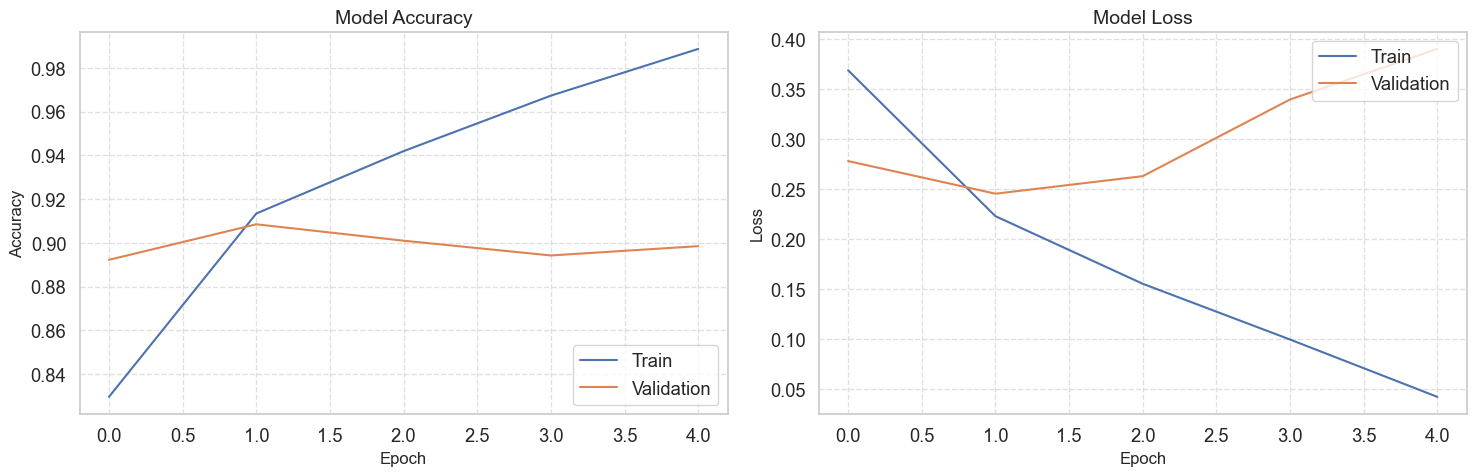

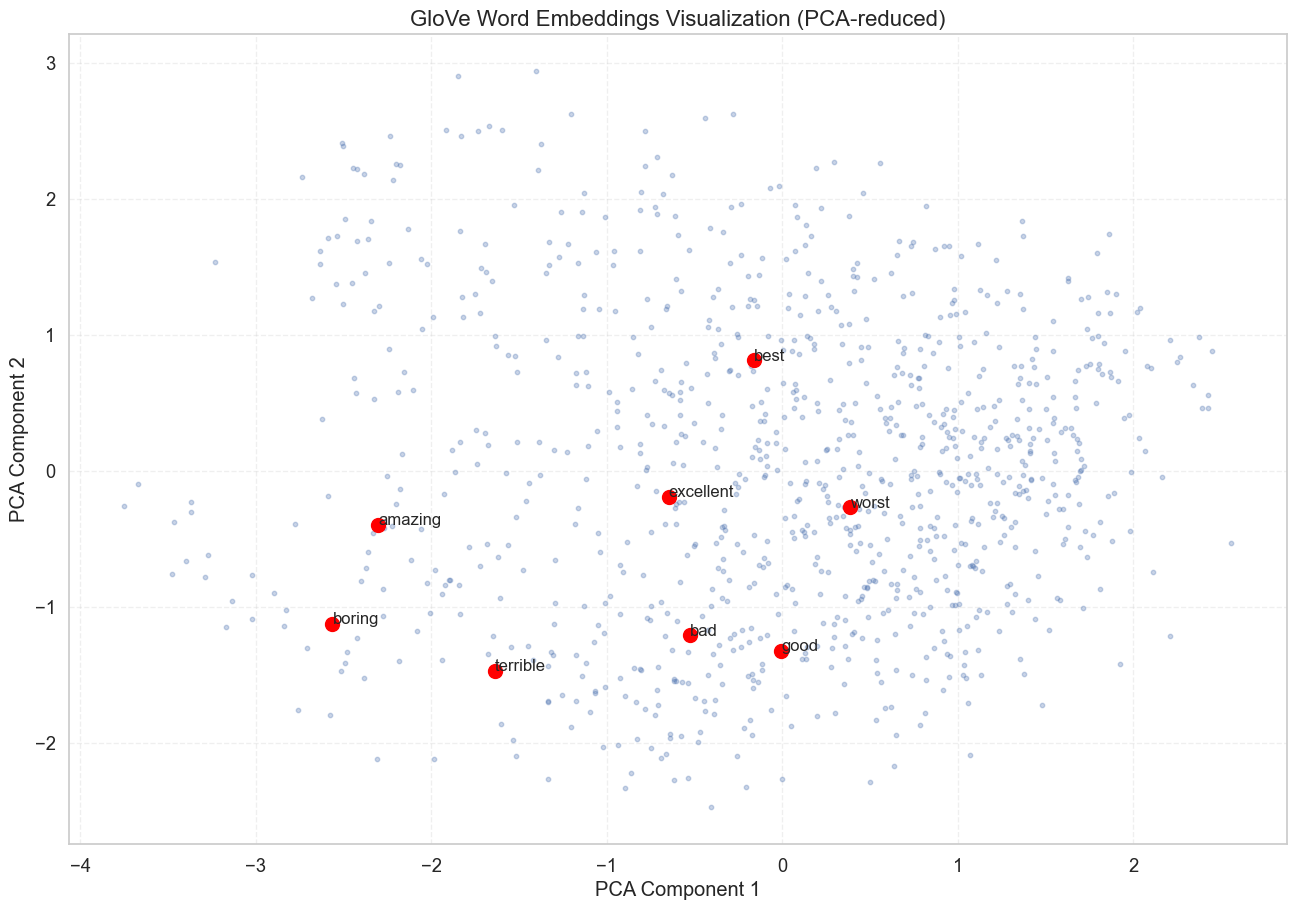

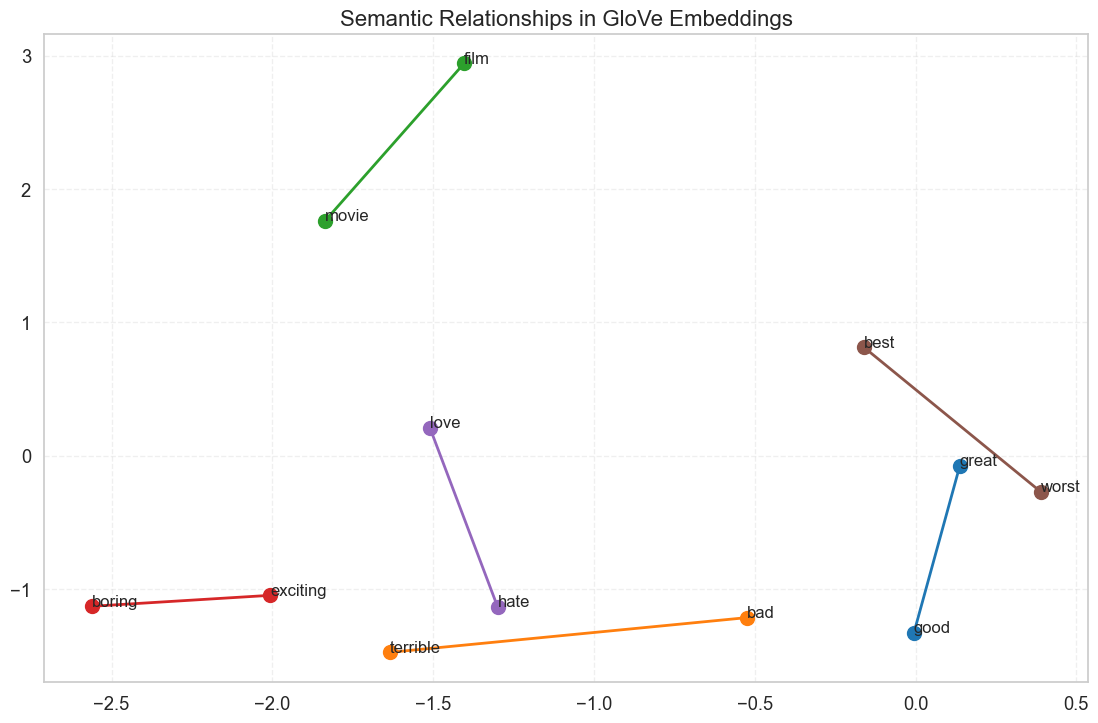

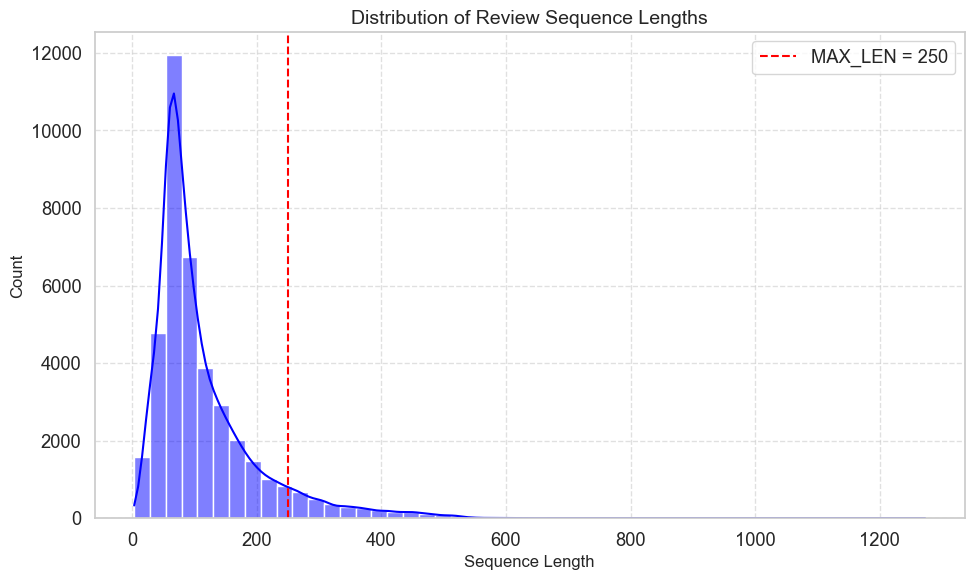

Sequence length statistics:
Average original length: 113.65 tokens
Maximum original length: 1273 tokens
Minimum original length: 3 tokens
Padded length (MAX_LEN): 250 tokens

Sequences truncated: 3,077 (7.69%)
Sequences padded: 36,885 (92.21%)
Sequences unchanged: 38 (0.10%)


In [19]:
# Visualize training history and attention patterns

# Training and validation metrics visualization
plt.figure(figsize=(15, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Create a visual representation of the GloVe embeddings
if embedding_matrix is not None:
    # PCA to reduce dimensions for visualization
    from sklearn.decomposition import PCA
    
    # Sample 1000 words from embedding matrix
    n_sample = 1000
    word_sample = min(n_sample, len(tokenizer.word_index))
    
    # Get word vectors and their labels
    word_vecs = embedding_matrix[1:word_sample+1]  # Skip padding token 0
    words = list(tokenizer.word_index.keys())[:word_sample]
    
    # Reduce dimensions
    pca = PCA(n_components=2)
    word_vecs_2d = pca.fit_transform(word_vecs)
    
    # Visualize the embeddings
    plt.figure(figsize=(14, 10))
    
    # Plot all sampled words
    plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], alpha=0.3, s=10)
    
    # Label some interesting words related to sentiment
    sentiment_words = ['excellent', 'terrible', 'good', 'bad', 'boring', 'amazing', 'worst', 'best']
    
    for word in sentiment_words:
        if word in tokenizer.word_index and tokenizer.word_index[word] <= word_sample:
            idx = tokenizer.word_index[word] - 1  # Adjust for 0-based indexing
            plt.scatter(word_vecs_2d[idx, 0], word_vecs_2d[idx, 1], s=100, color='red')
            plt.annotate(word, (word_vecs_2d[idx, 0], word_vecs_2d[idx, 1]), fontsize=12)
    
    plt.title('GloVe Word Embeddings Visualization (PCA-reduced)', fontsize=16)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()
    
    # Show semantic relationships between words
    plt.figure(figsize=(12, 8))
    plt.title('Semantic Relationships in GloVe Embeddings', fontsize=16)
    
    # Define some word pairs to visualize
    word_pairs = [
        ('good', 'great'), ('bad', 'terrible'),
        ('movie', 'film'), ('boring', 'exciting'),
        ('love', 'hate'), ('best', 'worst')
    ]
    
    # Plot connections between semantically related words
    for i, (word1, word2) in enumerate(word_pairs):
        if (word1 in tokenizer.word_index and tokenizer.word_index[word1] <= word_sample and
            word2 in tokenizer.word_index and tokenizer.word_index[word2] <= word_sample):
            
            idx1 = tokenizer.word_index[word1] - 1
            idx2 = tokenizer.word_index[word2] - 1
            
            plt.plot([word_vecs_2d[idx1, 0], word_vecs_2d[idx2, 0]],
                     [word_vecs_2d[idx1, 1], word_vecs_2d[idx2, 1]],
                     '-', linewidth=2, color=plt.cm.tab10(i))
            
            plt.scatter([word_vecs_2d[idx1, 0], word_vecs_2d[idx2, 0]],
                       [word_vecs_2d[idx1, 1], word_vecs_2d[idx2, 1]],
                       s=100, color=plt.cm.tab10(i))
            
            plt.annotate(word1, (word_vecs_2d[idx1, 0], word_vecs_2d[idx1, 1]), fontsize=12)
            plt.annotate(word2, (word_vecs_2d[idx2, 0], word_vecs_2d[idx2, 1]), fontsize=12)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

# Length Distribution of Sequences
plt.figure(figsize=(10, 6))
sns.histplot([len(seq) for seq in X_train_seq], bins=50, kde=True, color='blue')

# Add a vertical line for MAX_LEN
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN = {MAX_LEN}')
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Review Sequence Lengths', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Calculate padding statistics
original_lengths = [len(seq) for seq in X_train_seq]
padded_lengths = X_train_pad.shape[1]

too_long = sum(1 for l in original_lengths if l > MAX_LEN)
too_short = sum(1 for l in original_lengths if l < MAX_LEN)
exact_match = sum(1 for l in original_lengths if l == MAX_LEN)

print(f"Sequence length statistics:")
print(f"Average original length: {np.mean(original_lengths):.2f} tokens")
print(f"Maximum original length: {np.max(original_lengths)} tokens")
print(f"Minimum original length: {np.min(original_lengths)} tokens")
print(f"Padded length (MAX_LEN): {padded_lengths} tokens")
print()
print(f"Sequences truncated: {too_long:,} ({too_long/len(original_lengths)*100:.2f}%)")
print(f"Sequences padded: {too_short:,} ({too_short/len(original_lengths)*100:.2f}%)")
print(f"Sequences unchanged: {exact_match:,} ({exact_match/len(original_lengths)*100:.2f}%)")

In [20]:
# Make the PyTorch model work with the evaluation code in cell 20b907b3
# by adding a wrapper predict function to mimic Keras model interface
lstm_model = model

def predict_wrapper(X):
    return predict(lstm_model, X, device)

# Assign the wrapper function to mimic Keras model.predict
lstm_model.predict = predict_wrapper

In [22]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer # For BERT
from datasets import Dataset # For BERT
from tqdm import tqdm

# --- (Include your BiLSTMModelWithAttention class definition here) ---
# --- (And the BERT model loading/fine-tuning setup if not loaded globally) ---

# Make sure BiLSTMModelWithAttention class is defined as in the previous response
class BiLSTMModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=128, output_dim=1,
                 dropout=0.3, embedding_weights=None, freeze_embeddings=False):
        super(BiLSTMModelWithAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if embedding_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_weights))
            self.embedding.weight.requires_grad = not freeze_embeddings
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.attention_W = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.attention_v = nn.Linear(hidden_dim * 2, 1, bias=False)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm1_out, _ = self.lstm1(embedded)
        lstm2_out, _ = self.lstm2(lstm1_out)
        u = torch.tanh(self.attention_W(lstm2_out))
        att_scores = self.attention_v(u).squeeze(2)
        alpha = torch.softmax(att_scores, dim=1)
        context_vector = torch.bmm(alpha.unsqueeze(1), lstm2_out).squeeze(1)
        dropped_context = self.dropout_layer(context_vector)
        dense_outputs = self.fc(dropped_context)
        return torch.sigmoid(dense_outputs)


# --- Global Settings & Helper Functions ---
N_FOLDS = 3
CV_RANDOM_STATE = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# For reproducibility with PyTorch
def set_seed(seed_value=42):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    # Python random module (less critical for PyTorch but good practice)
    import random
    random.seed(seed_value)

set_seed(CV_RANDOM_STATE)


# --- TF-IDF Vectorizer (for Logistic Regression) ---
# (Assuming X_train_full, y_train_full are your complete original training text and labels)
# For demonstration, let's create dummy full data
# X_train_full = ["text " * 10 + str(i) for i in range(150)]
# y_train_full = np.array([0]*50 + [1]*50 + [0]*25 + [1]*25) # Example imbalanced data

# Ensure X_train_full and y_train_full are defined from your dataset
# X_train_full = X_train # If X_train from previous cells IS the full training data
# y_train_full = y_train # If y_train from previous cells IS the full training data


tfidf_ngram_vectorizer = TfidfVectorizer(
    max_features=10000, # Adjusted max_features for potentially smaller folds
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    use_idf=True
)

# --- Scorer Definition ---
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
    'recall_macro': make_scorer(recall_score, average='macro', zero_division=0),
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0)
}

# --- PyTorch LSTM Wrapper for Scikit-learn ---
class SklearnLSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, vocab_size=20000, embedding_dim=100, hidden_dim=128, dropout=0.3,
                 epochs=5, batch_size=64, learning_rate=1e-3, weight_decay=1e-5,
                 max_len=250, patience=2, random_state=None,
                 glove_embedding_matrix=None, freeze_glove=False):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.max_len = max_len
        self.patience = patience
        self.random_state = random_state # For reproducibility within the fit
        self.glove_embedding_matrix = glove_embedding_matrix
        self.freeze_glove = freeze_glove

        self.model_ = None
        self.tokenizer_ = None # Keras tokenizer
        self.classes_ = None # Store unique classes

    def _initialize_model(self):
        # Pass GloVe matrix and freeze flag directly
        self.model_ = BiLSTMModelWithAttention(
            vocab_size=self.vocab_size,
            embedding_dim=self.embedding_dim,
            hidden_dim=self.hidden_dim,
            dropout=self.dropout,
            embedding_weights=self.glove_embedding_matrix,
            freeze_embeddings=self.freeze_glove
        ).to(DEVICE)

    def fit(self, X, y):
        if self.random_state is not None:
            set_seed(self.random_state)

        self.classes_ = np.unique(y)
        if len(self.classes_) != 2:
            print("Warning: LSTM Wrapper currently designed for binary classification based on sigmoid output.")
        
        self.tokenizer_ = Tokenizer(num_words=self.vocab_size -1) # -1 because 0 is for padding
        self.tokenizer_.fit_on_texts(X)
        
        X_seq = self.tokenizer_.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, maxlen=self.max_len)
        
        X_tensor = torch.tensor(X_pad, dtype=torch.long)
        y_tensor = torch.tensor(y, dtype=torch.float) # y should be 0 or 1
        
        dataset = TensorDataset(X_tensor, y_tensor)
        # For CV, we use the whole X, y for this fold's training, no internal val split here
        # Early stopping within CV fold training could be complex to manage simply.
        # For simplicity, training for fixed epochs per fold.
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        self._initialize_model()
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(self.model_.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        
        # Simple training loop for fixed epochs (no early stopping here for CV simplicity)
        print(f"Fitting LSTM for {self.epochs} epochs...")
        for epoch in range(self.epochs):
            self.model_.train()
            epoch_loss = 0
            for inputs_b, labels_b in tqdm(train_loader, desc=f"LSTM Fold Epoch {epoch+1}/{self.epochs}", leave=False):
                inputs_b, labels_b = inputs_b.to(DEVICE), labels_b.to(DEVICE)
                optimizer.zero_grad()
                outputs = self.model_(inputs_b).squeeze(1)
                loss = criterion(outputs, labels_b)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model_.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()
            # print(f"Epoch {epoch+1} Loss: {epoch_loss/len(train_loader):.4f}")
        return self

    def predict_proba(self, X):
        if not self.model_ or not self.tokenizer_:
            raise ValueError("Model not fitted yet.")
        self.model_.eval()
        X_seq = self.tokenizer_.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, maxlen=self.max_len)
        X_tensor = torch.tensor(X_pad, dtype=torch.long)
        
        dataset = TensorDataset(X_tensor) # Dummy y_tensor for dataset creation
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        
        all_probas = []
        with torch.no_grad():
            for batch in tqdm(loader, desc="LSTM Predicting Probas", leave=False):
                inputs_b = batch[0].to(DEVICE)
                probas = self.model_(inputs_b).squeeze(1).cpu().numpy()
                all_probas.append(probas)
        
        probas_flat = np.concatenate(all_probas)
        # For binary classification, scikit-learn expects [prob_class_0, prob_class_1]
        return np.vstack([1 - probas_flat, probas_flat]).T

    def predict(self, X):
        probas = self.predict_proba(X)[:, 1] # Probability of class 1
        return (probas > 0.5).astype(int)

    def get_params(self, deep=True):
        return {
            "vocab_size": self.vocab_size, "embedding_dim": self.embedding_dim,
            "hidden_dim": self.hidden_dim, "dropout": self.dropout,
            "epochs": self.epochs, "batch_size": self.batch_size,
            "learning_rate": self.learning_rate, "weight_decay": self.weight_decay,
            "max_len": self.max_len, "patience": self.patience,
            "random_state": self.random_state,
            "glove_embedding_matrix": self.glove_embedding_matrix, # Important for cloning
            "freeze_glove": self.freeze_glove
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self


# --- PyTorch BERT Wrapper for Scikit-learn ---
class SklearnBertWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_name='bert-base-uncased', num_labels=2,
                 epochs=1, batch_size=8, learning_rate=3e-5, weight_decay=0.01,
                 max_length=128, warmup_ratio=0.06, random_state=None,
                 use_class_weights=False): # Added use_class_weights
        self.model_name = model_name
        self.num_labels = num_labels
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.max_length = max_length
        self.warmup_ratio = warmup_ratio
        self.random_state = random_state
        self.use_class_weights = use_class_weights # Store this

        self.tokenizer_ = None
        self.model_ = None
        self.trainer_ = None
        self.classes_ = None

    def _tokenize_function(self, examples):
        return self.tokenizer_(examples['text'], padding='max_length', truncation=True, max_length=self.max_length)

    def fit(self, X, y): # X is list of texts, y is list/array of labels
        if self.random_state is not None:
            set_seed(self.random_state)

        self.classes_ = np.unique(y)
        if len(self.classes_) != self.num_labels:
             print(f"Warning: num_labels ({self.num_labels}) might not match unique labels in data ({len(self.classes_)}).")

        self.tokenizer_ = BertTokenizerFast.from_pretrained(self.model_name)
        self.model_ = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_labels).to(DEVICE)

        train_df = pd.DataFrame({'text': X, 'label': y})
        train_dataset_hf = Dataset.from_pandas(train_df)
        train_dataset_tokenized = train_dataset_hf.map(self._tokenize_function, batched=True)
        train_dataset_tokenized = train_dataset_tokenized.remove_columns(["text"])
        train_dataset_tokenized.set_format("torch")

        training_args = TrainingArguments(
            output_dir=f'./results_bert_cv_fold_temp', # Temporary for each fold
            num_train_epochs=self.epochs,
            per_device_train_batch_size=self.batch_size,
            # No evaluation during CV fold training for simplicity, eval is done by cross_validate
            eval_strategy="no",
            save_strategy="no", # Don't save checkpoints during CV fold
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
            warmup_ratio=self.warmup_ratio,
            logging_steps=max(1, len(train_dataset_tokenized) // (self.batch_size * 4) ), # Log a few times per epoch
            report_to="none", # No external reporting
            fp16=torch.cuda.is_available(),
            seed=self.random_state or 42, # Ensure trainer also uses a seed
            disable_tqdm=True, # Disable internal tqdm as cross_validate might have its own
        )
        
        custom_trainer_to_use = Trainer
        if self.use_class_weights and self.num_labels == 2:
            class_counts = pd.Series(y).value_counts().sort_index().to_list()
            if len(class_counts) == 2: # Ensure we have counts for both classes
                total_samples = sum(class_counts)
                # Check for imbalance (e.g., minority < 40%)
                if total_samples > 0 and min(class_counts) / total_samples < 0.4:
                    print("BERT Wrapper: Class imbalance detected. Calculating weights.")
                    weights = [total_samples / (self.num_labels * count) if count > 0 else 1.0 for count in class_counts]
                    class_weights_tensor = torch.tensor(weights, dtype=torch.float).to(DEVICE)
                    print(f"BERT Wrapper: Using class weights: {weights}")

                    class CustomTrainerWithWeights(Trainer):
                        def compute_loss(self, model, inputs, return_outputs=False):
                            labels = inputs.pop("labels")
                            outputs = model(**inputs)
                            logits = outputs.get("logits")
                            loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor.to(logits.device))
                            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
                            return (loss, outputs) if return_outputs else loss
                    custom_trainer_to_use = CustomTrainerWithWeights
                else:
                    print("BERT Wrapper: Classes seem balanced or do not meet imbalance criteria. Not using weights.")
            else:
                print("BERT Wrapper: Could not get counts for 2 classes. Not using weights.")


        self.trainer_ = custom_trainer_to_use(
            model=self.model_,
            args=training_args,
            train_dataset=train_dataset_tokenized,
            # No eval_dataset here, cross_validate handles splitting
        )
        print(f"Fitting BERT for {self.epochs} epochs...")
        self.trainer_.train()
        return self

    def predict_proba(self, X): # X is list of texts
        if not self.model_ or not self.tokenizer_ or not self.trainer_:
            raise ValueError("Model not fitted yet.")
        self.model_.eval() # Ensure model is in eval mode

        # Create a dummy test dataset for Hugging Face Trainer's predict method
        test_df = pd.DataFrame({'text': X, 'label': [0]*len(X)}) # Dummy labels
        test_dataset_hf = Dataset.from_pandas(test_df)
        test_dataset_tokenized = test_dataset_hf.map(self._tokenize_function, batched=True)
        test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text", "label"])
        test_dataset_tokenized.set_format("torch")

        print(f"BERT Predicting Probas for {len(X)} samples...")
        predictions = self.trainer_.predict(test_dataset_tokenized)
        logits = predictions.predictions
        probas = torch.softmax(torch.tensor(logits), dim=-1).cpu().numpy()
        return probas # Returns [prob_class_0, prob_class_1, ...]

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def get_params(self, deep=True):
        return {
            "model_name": self.model_name, "num_labels": self.num_labels,
            "epochs": self.epochs, "batch_size": self.batch_size,
            "learning_rate": self.learning_rate, "weight_decay": self.weight_decay,
            "max_length": self.max_length, "warmup_ratio": self.warmup_ratio,
            "random_state": self.random_state, "use_class_weights": self.use_class_weights
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        # Re-initialize model if critical params change (though CV usually clones)
        # if 'model_name' in parameters or 'num_labels' in parameters:
        #     self.model_ = None # Force re-init
        return self


# --- `cv_evaluate_model` Function (largely the same) ---
def cv_evaluate_model(model, X, y, model_name, is_deep_learning=False):
    print(f"\nEvaluating {model_name} with {N_FOLDS}-fold CV...")
    start_time = time.time()
    
    # For deep learning models, X is raw text. For LR, X is TF-IDF.
    # `cross_validate` will pass slices of X and y to model.fit()
    cv_results = cross_validate(
        model, X, y,
        cv=skf,
        scoring=scoring,
        return_train_score=False, # Usually not needed and saves computation
        n_jobs=1 if is_deep_learning else -1, # DL models often manage their own parallelism or GPU
        verbose=1 if is_deep_learning else 0 # More verbose for DL models due to time
    )
    
    elapsed_time = time.time() - start_time
    
    results_dict = {
        'model_name': model_name,
        'time': elapsed_time,
        'fit_time_mean': cv_results['fit_time'].mean(),
        'score_time_mean': cv_results['score_time'].mean(),
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'precision_mean': cv_results['test_precision_macro'].mean(),
        'precision_std': cv_results['test_precision_macro'].std(),
        'recall_mean': cv_results['test_recall_macro'].mean(),
        'recall_std': cv_results['test_recall_macro'].std(),
        'f1_mean': cv_results['test_f1_macro'].mean(),
        'f1_std': cv_results['test_f1_macro'].std(),
    }
    
    print(f"{model_name} CV Results:")
    print(f"  Total CV time: {results_dict['time']:.2f} seconds")
    print(f"  Avg Fit time: {results_dict['fit_time_mean']:.2f}s, Avg Score time: {results_dict['score_time_mean']:.2f}s")
    print(f"  Accuracy: {results_dict['accuracy_mean']:.4f} (±{results_dict['accuracy_std']:.4f})")
    print(f"  Precision (Macro): {results_dict['precision_mean']:.4f} (±{results_dict['precision_std']:.4f})")
    print(f"  Recall (Macro): {results_dict['recall_mean']:.4f} (±{results_dict['recall_std']:.4f})")
    print(f"  F1 (Macro): {results_dict['f1_mean']:.4f} (±{results_dict['f1_std']:.4f})")
    
    # No model.fit(X,y) here, as CV does fitting. Final model training is separate.
    return results_dict


# --- Main Cross-Validation Execution ---
all_cv_results = []
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=CV_RANDOM_STATE)

# Prepare Data (ensure X_train_full and y_train_full are your full training dataset)
# These should be lists/arrays of raw text and labels for BERT/LSTM
# For Logistic Regression, we'll create TF-IDF features *inside* the loop or pass pre-fitted vectorizer.

# Make sure these are defined:
# X_train_full = [...] # list of strings
# y_train_full = np.array([...]) # numpy array of labels (0 or 1)

# Example (replace with your actual full training data)
if 'X_train' in globals() and 'y_train' in globals():
    X_train_full = X_train if isinstance(X_train, list) else X_train.tolist() # Ensure list for tokenizers
    y_train_full = y_train.values if hasattr(y_train, 'values') else np.array(y_train) # Ensure numpy array
else:
    print("Error: X_train and y_train (full dataset) not found. Please define them.")
    # Dummy data for the script to run if X_train/y_train are missing
    X_train_full = ["Sample positive text for CV " + str(i) for i in range(75)] + \
                   ["Sample negative text for CV " + str(i) for i in range(75)]
    y_train_full = np.array([1]*75 + [0]*75)


print("\n" + "="*50)
print(f"Starting {N_FOLDS}-fold cross-validation for selected models...")

# 1. Logistic Regression
print("\n--- Logistic Regression CV ---")
# For LR, we need TF-IDF features. We fit TF-IDF on the whole training set first.
# This is common practice, though strictly, TF-IDF should be fit *inside* each CV fold.
# For simplicity here, we fit it once.
# Alternatively, use a Pipeline.
X_train_tfidf_full = tfidf_ngram_vectorizer.fit_transform(X_train_full)

lr_model_cv = LogisticRegression(
    C=1.0, # Simpler C for CV, tuning can be done separately
    solver='liblinear', # Good for smaller datasets, handles L1/L2
    penalty='l2',
    max_iter=1000,
    class_weight='balanced',
    random_state=CV_RANDOM_STATE
)
lr_cv_results = cv_evaluate_model(lr_model_cv, X_train_tfidf_full, y_train_full, "Logistic Regression", is_deep_learning=False)
all_cv_results.append(lr_cv_results)


# 2. LSTM Model
print("\n--- LSTM Model CV ---")
# LSTM Wrapper needs GloVe. Load it once if used.
# (Assuming GLOVE_FILE_PATH and GLOVE_DIM are defined, and actual_embedding_dim, embedding_matrix from prior LSTM setup)
# If `embedding_matrix` is from the previous LSTM setup (trained on full data), it's okay for CV
# as the wrapper re-initializes and fits the model from scratch in each fold.
# The pre-loaded embedding_matrix itself isn't "trained" on folds yet.

# Check if GloVe embedding matrix is available (from previous LSTM setup)
glove_matrix_for_cv = None
lstm_embedding_dim_for_cv = 100 # Fallback or GloVe dim
freeze_glove_for_cv = True # Example: freeze during CV for speed, fine-tune in final model

if 'embedding_matrix' in globals() and embedding_matrix is not None and 'GLOVE_DIM' in globals():
    glove_matrix_for_cv = embedding_matrix
    lstm_embedding_dim_for_cv = GLOVE_DIM
    print(f"Using pre-loaded GloVe matrix (dim: {GLOVE_DIM}) for LSTM CV.")
    # freeze_glove_for_cv = False # Option to fine-tune during CV, but slower
else:
    print("GloVe matrix not found or not specified. LSTM will use random embeddings for CV.")
    # vocab_size for LSTM wrapper should be MAX_WORDS + 1
    # embedding_dim for LSTM wrapper should match GloVe or be a fallback

lstm_wrapper = SklearnLSTMWrapper(
    vocab_size=20000 + 1, # From your LSTM hyperparams (MAX_WORDS + 1)
    embedding_dim=lstm_embedding_dim_for_cv,
    hidden_dim=64, # Smaller hidden_dim for faster CV
    epochs=3,      # Fewer epochs for faster CV
    batch_size=64,
    max_len=100,   # Shorter max_len for faster CV
    random_state=CV_RANDOM_STATE,
    glove_embedding_matrix=glove_matrix_for_cv,
    freeze_glove=freeze_glove_for_cv
)
# LSTM uses raw text X_train_full
lstm_cv_results = cv_evaluate_model(lstm_wrapper, X_train_full, y_train_full, "BiLSTM with Attention", is_deep_learning=True)
all_cv_results.append(lstm_cv_results)


# 3. BERT Model
print("\n--- BERT Model CV ---")
bert_wrapper = SklearnBertWrapper(
    model_name='bert-base-uncased',
    num_labels=2, # Assuming binary classification
    epochs=1,       # Very few epochs for faster CV. BERT is powerful.
    batch_size=16,  # Can be larger if GPU memory allows
    max_length=128, # Max sequence length for BERT
    random_state=CV_RANDOM_STATE,
    use_class_weights=True # Example: try with class weights
)
# BERT uses raw text X_train_full
bert_cv_results = cv_evaluate_model(bert_wrapper, X_train_full, y_train_full, "BERT", is_deep_learning=True)
all_cv_results.append(bert_cv_results)


# --- Visualize CV Results ---
print("\n" + "="*50)
print("Cross-Validation Summary:")

cv_df = pd.DataFrame(all_cv_results)
print(cv_df[['model_name', 'accuracy_mean', 'f1_mean', 'time']])

# Plotting
model_names_plot = cv_df['model_name'].tolist()
accuracies_plot = cv_df['accuracy_mean'].tolist()
accuracy_std_plot = cv_df['accuracy_std'].tolist()
f1_scores_plot = cv_df['f1_mean'].tolist()
f1_std_plot = cv_df['f1_std'].tolist()

plt.figure(figsize=(12, 7))
x_plot = np.arange(len(model_names_plot))
width = 0.35

rects1 = plt.bar(x_plot - width/2, accuracies_plot, width, label='CV Accuracy', color='#5DA5DA', yerr=accuracy_std_plot, capsize=5)
rects2 = plt.bar(x_plot + width/2, f1_scores_plot, width, label='CV F1 (Macro)', color='#F15854', yerr=f1_std_plot, capsize=5)

plt.xlabel('Models', fontsize=12)
plt.ylabel('Scores', fontsize=12)
plt.title(f'{N_FOLDS}-Fold Cross-Validation Comparison', fontsize=14)
plt.xticks(x_plot, model_names_plot, fontsize=10, rotation=15, ha="right")
min_score = cv_df[['accuracy_mean', 'f1_mean']].min().min()
plt.ylim(max(0, min_score - 0.1), 1.0) # Adjust y-axis limits
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

print("\nCross-validation finished.")

Using device: cuda

Starting 3-fold cross-validation for selected models...

--- Logistic Regression CV ---

Evaluating Logistic Regression with 3-fold CV...
Logistic Regression CV Results:
  Total CV time: 2.93 seconds
  Avg Fit time: 0.63s, Avg Score time: 0.01s
  Accuracy: 0.8920 (±0.0013)
  Precision (Macro): 0.8922 (±0.0013)
  Recall (Macro): 0.8919 (±0.0013)
  F1 (Macro): 0.8919 (±0.0013)

--- LSTM Model CV ---
Using pre-loaded GloVe matrix (dim: 100) for LSTM CV.

Evaluating BiLSTM with Attention with 3-fold CV...
Fitting LSTM for 3 epochs...


Fitting LSTM for 3 epochs...


Fitting LSTM for 3 epochs...


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.9s finished                                                  


BiLSTM with Attention CV Results:
  Total CV time: 35.97 seconds
  Avg Fit time: 10.93s, Avg Score time: 1.04s
  Accuracy: 0.7953 (±0.0105)
  Precision (Macro): 0.8001 (±0.0050)
  Recall (Macro): 0.7953 (±0.0105)
  F1 (Macro): 0.7943 (±0.0116)

--- BERT Model CV ---

Evaluating BERT with 3-fold CV...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/26666 [00:00<?, ? examples/s]

BERT Wrapper: Classes seem balanced or do not meet imbalance criteria. Not using weights.
Fitting BERT for 1 epochs...
{'loss': 0.4439, 'grad_norm': 10.860955238342285, 'learning_rate': 2.4022988505747127e-05, 'epoch': 0.2495500899820036}
{'loss': 0.3328, 'grad_norm': 5.372504711151123, 'learning_rate': 1.6053639846743297e-05, 'epoch': 0.4991001799640072}


[Parallel(n_jobs=1)]: Done   0 out of   1 | elapsed: 14.5min remaining: 14.5min


KeyboardInterrupt: 

In [ ]:
# GPU Memory Management Functions
import torch
import gc
import os

def clear_gpu_memory():
    """Clear GPU memory cache and run garbage collection"""
    if torch.cuda.is_available():
        # Empty CUDA cache
        torch.cuda.empty_cache()
        
        # Force garbage collection
        gc.collect()
        
        # Print memory stats before and after clearing
        print("GPU memory before clearing:")
        print_gpu_memory_stats()
        
        # Explicitly delete any leftover tensors on CUDA
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) and obj.is_cuda:
                    del obj
            except:
                pass
        
        # Run garbage collection again
        gc.collect()
        torch.cuda.empty_cache()
        
        print("\nGPU memory after clearing:")
        print_gpu_memory_stats()
    else:
        print("No GPU available.")

def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} - {torch.cuda.get_device_name(i)}:")
            allocated = torch.cuda.memory_allocated(i) / (1024 ** 3)
            reserved = torch.cuda.memory_reserved(i) / (1024 ** 3)
            print(f"  Allocated: {allocated:.2f} GB")
            print(f"  Reserved:  {reserved:.2f} GB")
    else:
        print("No GPU available.")

# Check current GPU memory usage
print("Current GPU memory usage:")
print_gpu_memory_stats()

# Clear GPU memory if needed
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Getting predictions for BiLSTM (GloVe)...


OutOfMemoryError: CUDA out of memory. Tried to allocate 954.00 MiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 7.82 GiB is allocated by PyTorch, and 1.21 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

--- Evaluating Logistic Regression ---

📊 EVALUATION RESULTS: Logistic Regression

🔢 Performance Metrics:
  Accuracy: 0.8953
  Precision (Macro): 0.8955
  Recall (Macro): 0.8953
  F1 Score (Macro): 0.8953
  Precision (Negative): 0.9039
  Precision (Positive): 0.8870
  Recall (Negative): 0.8846
  Recall (Positive): 0.9060
  F1 Score (Negative): 0.8942
  F1 Score (Positive): 0.8964
  AUC: 0.9613

⏱️ Prediction time: 0.01 seconds for 10000 samples

📈 VISUALIZATIONS


<Figure size 1000x800 with 0 Axes>

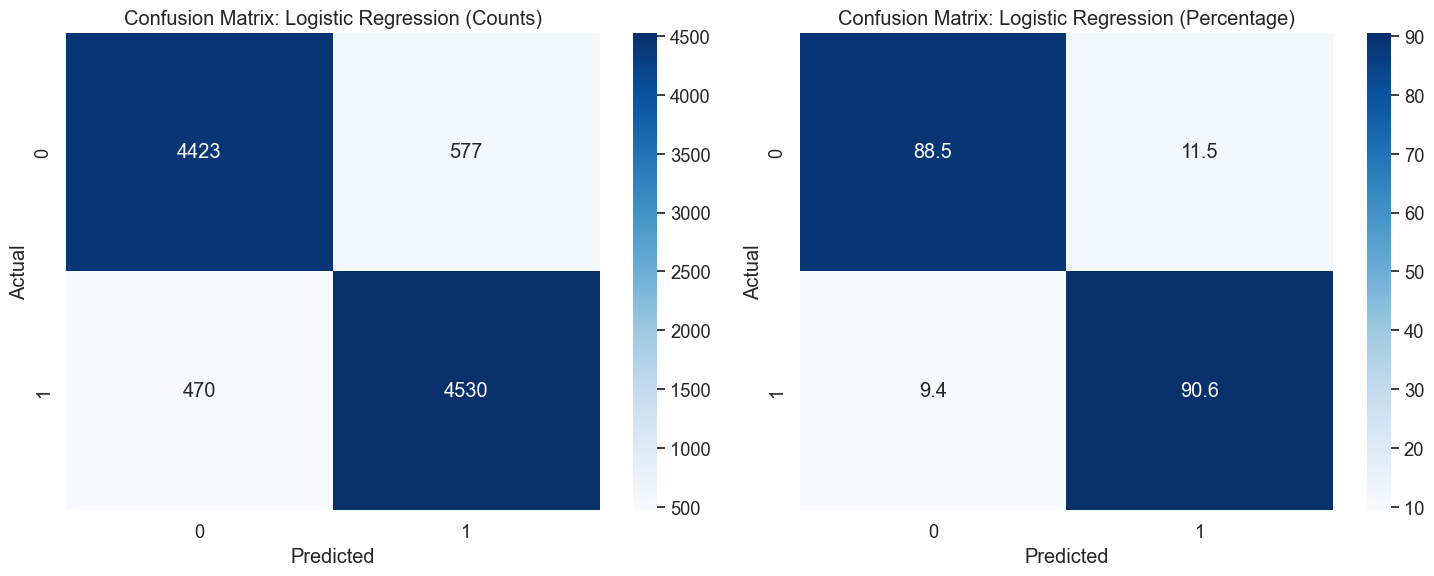

<Figure size 1200x600 with 0 Axes>

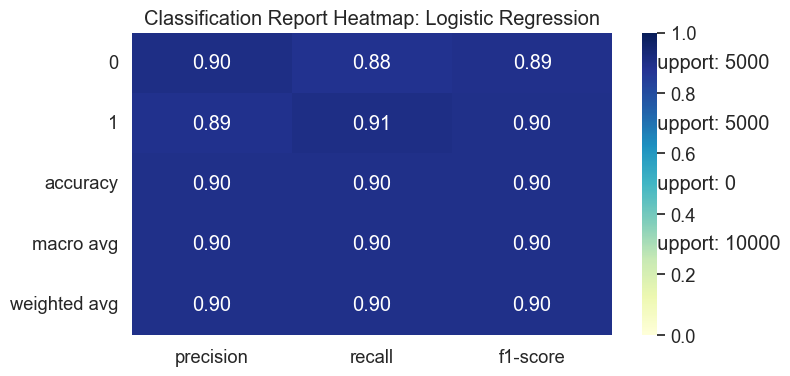

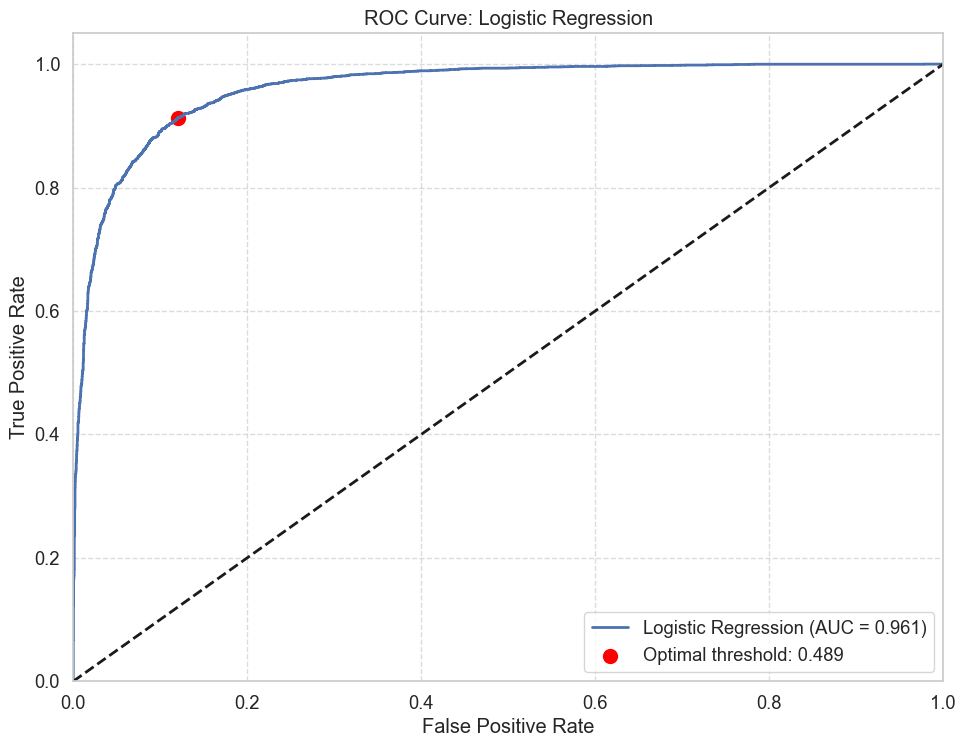

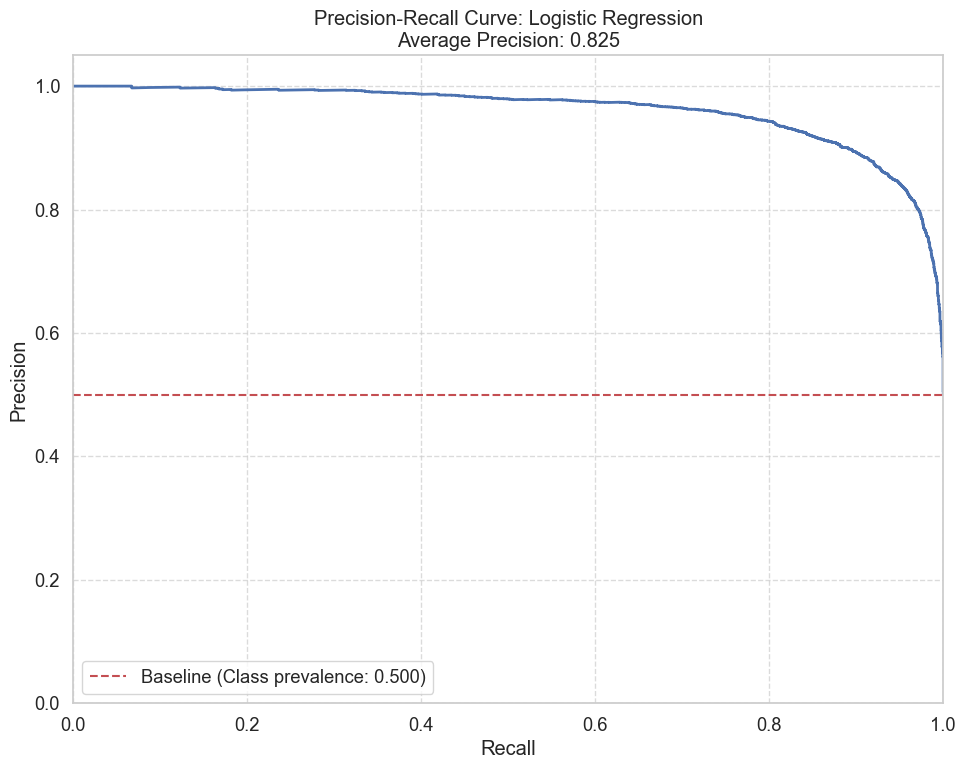

<Figure size 1200x500 with 0 Axes>

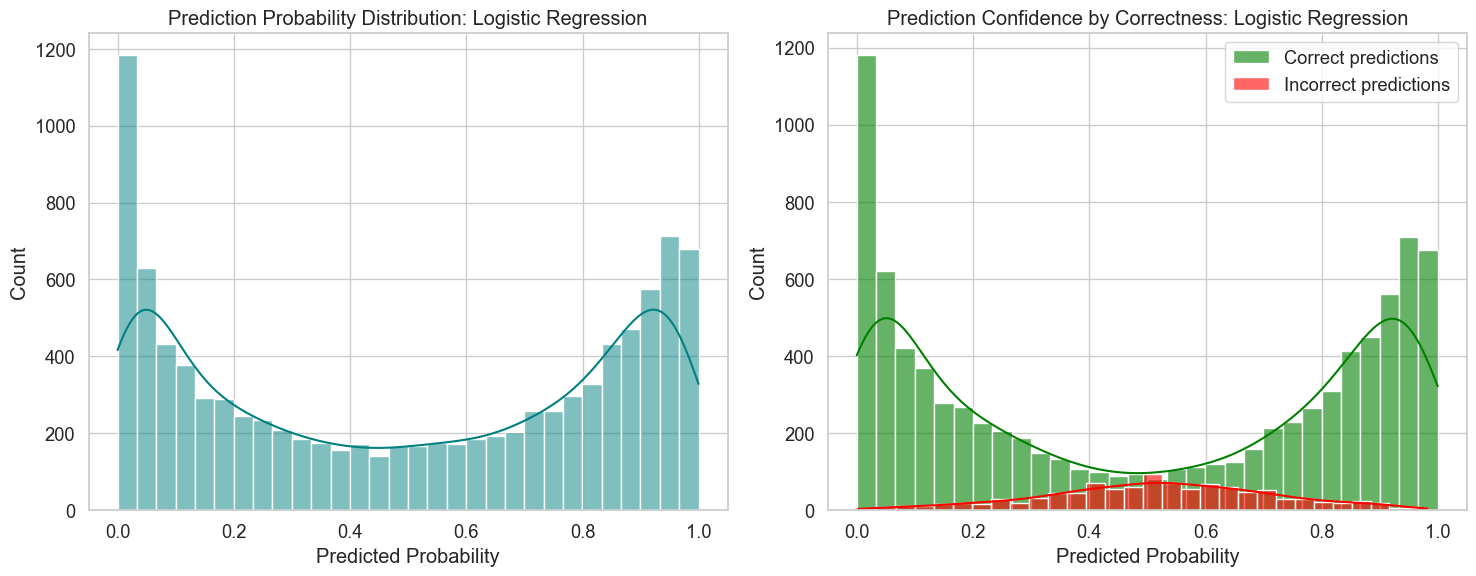


🔍 ERROR ANALYSIS

Top 5 confident misclassifications:

Example 1:
  Text: sleek sexy movie must see upon multiple viewing one truly understand uniqueness film personally enjo...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9817

Example 2:
  Text: major payne film major make life living hell small group boy marine film really lot offer provides s...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9686

Example 3:
  Text: excited hyped watching film promos first came november looked awesome song quite disappointed went w...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9592

Example 4:
  Text: saw winnie heffalump couple day ago nice story based well known character created milne although win...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9583

Example 5:
  Text: story go something like small town girl katie jessica simpson decides visit boyfriend big city arriv...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9571


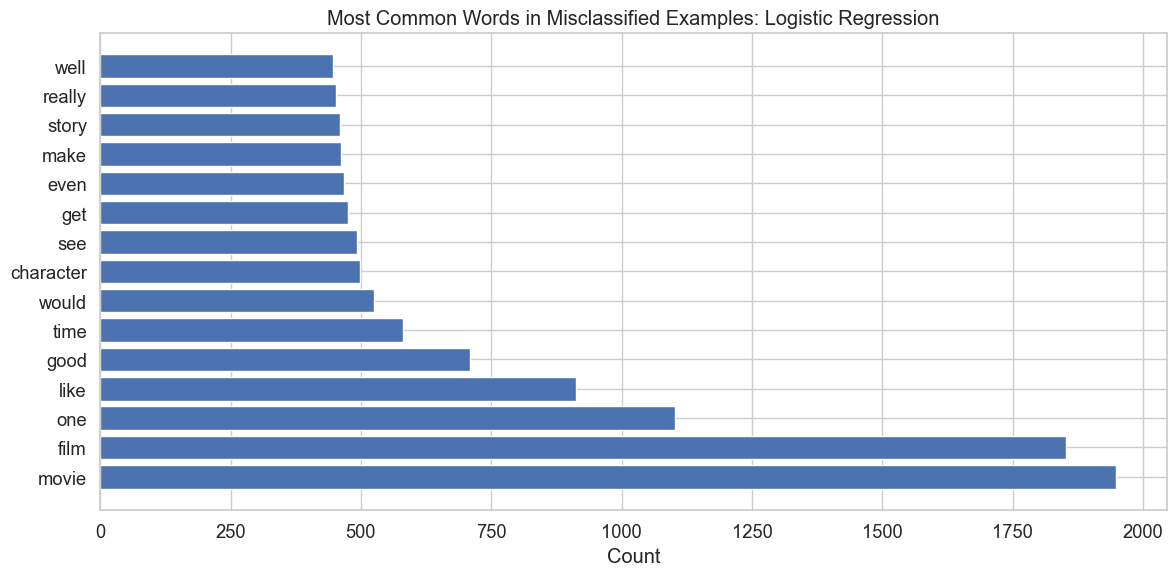

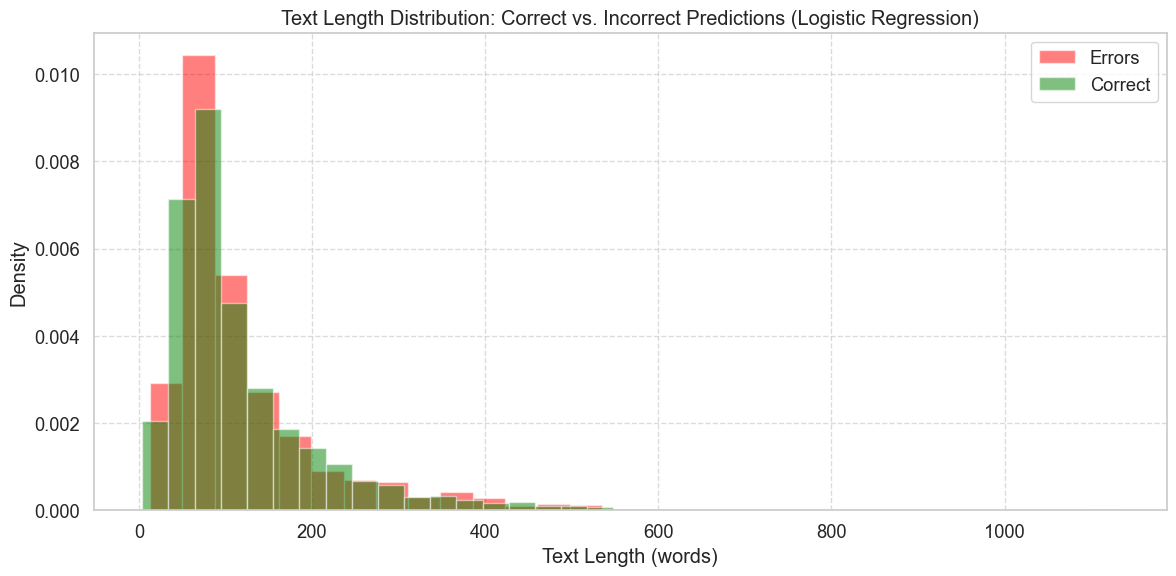


--- Evaluating BiLSTM with GloVe Embeddings ---
Getting predictions for BiLSTM (GloVe)...


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.38 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Of the allocated memory 6.82 GiB is allocated by PyTorch, and 1.28 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import softmax
from collections import Counter
import time

def evaluate_model(model, X, y, model_name, is_dl=False, is_bert=False, X_raw=None):
    """
    Enhanced model evaluation function with detailed metrics and visualizations
    
    Parameters:
    - model: The trained model to evaluate
    - X: Feature data in the format expected by the model
    - y: True labels
    - model_name: Name of the model for display
    - is_dl: Flag for deep learning models
    - is_bert: Flag for BERT-based models
    - X_raw: Optional raw text data for error analysis
    """
    start_time = time.time()
    y_true = y # Actual labels
    
    # Get predictions based on model type
    if is_bert:
        print(f"Getting predictions for {model_name}...")
        raw_predictions = model.predict(X)
        logits = raw_predictions.predictions
        y_pred_proba_all = softmax(logits, axis=1)
        y_pred_proba = y_pred_proba_all[:, 1]  # Probability of positive class
        y_pred = np.argmax(logits, axis=1)
        
    elif is_dl:
        print(f"Getting predictions for {model_name}...")
        y_pred_proba_dl = model.predict(X)
        y_pred = (y_pred_proba_dl > 0.5).astype(int).flatten()
        y_pred_proba = y_pred_proba_dl.flatten()
        
    else:
        y_pred = model.predict(X)
        if hasattr(model, 'predict_proba'):
            y_pred_proba_sklearn = model.predict_proba(X)
            y_pred_proba = y_pred_proba_sklearn[:, 1]
        else:
            y_pred_proba = y_pred
    
    prediction_time = time.time() - start_time
    
    # 1. Basic metrics with enhanced formatting
    print(f"\n{'='*50}")
    print(f"📊 EVALUATION RESULTS: {model_name}")
    print(f"{'='*50}")
    
    # Calculate all metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    # For binary classification, also calculate class-specific metrics
    precision_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    # Format into a metrics DataFrame for better display
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)'],
        'Value': [accuracy, precision_macro, recall_macro, f1_macro]
    })
    
    # Add class-specific metrics if binary
    if len(np.unique(y_true)) == 2:
        class_metrics = pd.DataFrame({
            'Metric': ['Precision (Negative)', 'Precision (Positive)', 
                      'Recall (Negative)', 'Recall (Positive)',
                      'F1 Score (Negative)', 'F1 Score (Positive)'],
            'Value': [precision_class[0], precision_class[1],
                     recall_class[0], recall_class[1],
                     f1_class[0], f1_class[1]]
        })
        metrics_df = pd.concat([metrics_df, class_metrics], ignore_index=True)
    
    print("\n🔢 Performance Metrics:")
    for index, row in metrics_df.iterrows():
        print(f"  {row['Metric']}: {row['Value']:.4f}")
    
    # Try to calculate AUC
    try:
        # Ensure y_pred_proba is 1D with valid probabilities
        if y_pred_proba.ndim > 1 and y_pred_proba.shape[1] > 1:
            y_pred_proba_auc = y_pred_proba[:, 1]
        elif y_pred_proba.ndim > 1 and y_pred_proba.shape[1] == 1:
            y_pred_proba_auc = y_pred_proba.flatten()
        else:
            y_pred_proba_auc = y_pred_proba
            
        auc_score = roc_auc_score(y_true, y_pred_proba_auc)
        print(f"  AUC: {auc_score:.4f}")
    except ValueError as e:
        print(f"  ⚠️ Could not calculate AUC: {e}")
    
    print(f"\n⏱️ Prediction time: {prediction_time:.2f} seconds for {len(y_true)} samples")
    
    # 2. Visualizations Section
    print("\n📈 VISUALIZATIONS")
    
    # 2.1 Confusion Matrix with percentages and counts
    plt.figure(figsize=(10, 8))
    
    # Create two subplots for raw counts and percentages
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")
    ax1.set_title(f"Confusion Matrix: {model_name} (Counts)")
    
    # Percentage confusion matrix
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Actual")
    ax2.set_title(f"Confusion Matrix: {model_name} (Percentage)")
    
    plt.tight_layout()
    plt.show()
    
    # 2.2 Classification Report as Heatmap
    plt.figure(figsize=(12, 6))
    
    # Get classification report as dict and convert to dataframe
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    
    # Drop support column for heatmap clarity (will show as text)
    supports = report_df['support'].values
    report_df = report_df.drop('support', axis=1)
    
    # Generate heatmap
    plt.figure(figsize=(8, 4))
    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f', vmin=0, vmax=1)
    plt.title(f'Classification Report Heatmap: {model_name}')
    
    # Annotate with support values
    for i, support in enumerate(supports[:-1]):  # Skip 'avg' rows
        plt.text(3.2, i + 0.5, f'Support: {int(support)}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # 2.3 ROC Curve (for binary classification)
    if len(np.unique(y_true)) == 2:
        plt.figure(figsize=(10, 8))
        
        # Calculate ROC curve points
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba_auc)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc_score:.3f})')
        
        # Plot diagonal reference line
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        
        # Add key threshold points
        # Find point closest to (0,1) - optimal threshold
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        
        # Plot the optimal point
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', s=100, 
                   label=f'Optimal threshold: {optimal_threshold:.3f}')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {model_name}')
        plt.legend(loc="lower right")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
        
        # 2.4 Precision-Recall Curve
        plt.figure(figsize=(10, 8))
        
        # Calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba_auc)
        
        # Plot precision-recall curve
        plt.plot(recall, precision, lw=2)
        
        # Calculate average precision (area under PR curve)
        avg_precision = np.mean(precision)
        
        # Add baseline
        plt.axhline(y=sum(y_true)/len(y_true), color='r', linestyle='--', 
                   label=f'Baseline (Class prevalence: {sum(y_true)/len(y_true):.3f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve: {model_name}\nAverage Precision: {avg_precision:.3f}')
        plt.legend(loc="lower left")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()
    
    # 2.5 Prediction Probability Distribution
    plt.figure(figsize=(12, 5))
    
    # Create subplots - one for all, one for each class
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Overall probability distribution
    sns.histplot(y_pred_proba_auc, bins=30, kde=True, ax=ax1, color='teal')
    ax1.set_title(f'Prediction Probability Distribution: {model_name}')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Count')
    
    # Probability distribution by class
    correct_probs = y_pred_proba_auc[y_pred == y_true]
    incorrect_probs = y_pred_proba_auc[y_pred != y_true]
    
    # Plot distributions of correct vs incorrect predictions
    if len(correct_probs) > 0:
        sns.histplot(correct_probs, bins=30, kde=True, ax=ax2, color='green', 
                    label='Correct predictions', alpha=0.6)
    if len(incorrect_probs) > 0:
        sns.histplot(incorrect_probs, bins=30, kde=True, ax=ax2, color='red', 
                   label='Incorrect predictions', alpha=0.6)
        
    ax2.set_title(f'Prediction Confidence by Correctness: {model_name}')
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Count')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3. Error Analysis (If raw text is provided)
    if X_raw is not None and len(X_raw) == len(y_true):
        print("\n🔍 ERROR ANALYSIS")
        
        # Find indices of misclassified examples
        # np.where returns positional indices, ensure y_true and y_pred are comparable
        # If y_true is a Series and y_pred is a NumPy array, pandas aligns y_pred to y_true's index for the comparison.
        # The resulting error_indices are positional with respect to y_true's current order.
        error_indices = np.where(y_pred != y_true)[0]
        
        if len(error_indices) > 0:
            # Convert y_true to a NumPy array to allow positional indexing with error_indices
            # This is crucial if y_true is a pandas Series with a non-integer or non-sequential index.
            if isinstance(y_true, (pd.Series, pd.DataFrame)):
                y_true_np = y_true.to_numpy()
            else:
                # Handles lists and existing numpy arrays
                y_true_np = np.asarray(y_true)

            # Ensure y_true_np is 1D (common for binary classification labels)
            if y_true_np.ndim > 1:
                if y_true_np.shape[1] == 1: # If it's a column vector
                    y_true_np = y_true_np.flatten()
                else:
                    # This case might indicate y was a multi-column structure not intended for this part of analysis.
                    # For robustness, we might print a warning and take the first column,
                    # but ideally, y_true should be 1D for binary classification context.
                    print(f"Warning: y_true for error analysis has shape {y_true_np.shape}. Attempting to use its first column/flattening. Review if y is structured as expected.")
                    # Fallback: try to flatten. If it's genuinely multi-label/multi-output, this part of error analysis might need rethinking.
                    y_true_np = y_true_np.flatten() # Or y_true_np[:,0] if a specific column is always the target

            # X_raw is expected to be a list (due to .tolist() in its creation)
            # y_pred is a numpy array
            # y_pred_proba_auc is a numpy array
            
            # Using direct array indexing for y_true_np, y_pred, and y_pred_proba_auc
            # and list comprehension for X_raw (which is a list)
            errors_df = pd.DataFrame({
                'Text': [X_raw[i] for i in error_indices],
                'True_Label': y_true_np[error_indices].tolist(), # Index the numpy array version
                'Predicted_Label': y_pred[error_indices].tolist(),
                'Confidence': y_pred_proba_auc[error_indices].tolist() 
            })
            
            # Sort by confidence to find the most confident errors
            errors_df = errors_df.sort_values(by='Confidence', ascending=False)
            
            # Display most confident misclassifications
            n_examples = min(5, len(errors_df))
            print(f"\nTop {n_examples} confident misclassifications:")
            for i in range(n_examples):
                row = errors_df.iloc[i]
                text_preview = row['Text'][:100] + "..." if len(row['Text']) > 100 else row['Text']
                print(f"\nExample {i+1}:")
                print(f"  Text: {text_preview}")
                print(f"  True Label: {row['True_Label']}")
                print(f"  Predicted Label: {row['Predicted_Label']}")
                print(f"  Confidence: {row['Confidence']:.4f}")
            
            # Analyze common patterns in errors
            # For example, find most common words in errors
            if isinstance(X_raw[0], str):  # Ensure we're working with text
                # Get texts for error_indices directly from X_raw list
                error_texts = [X_raw[i] for i in error_indices]
                all_error_words = " ".join(error_texts).split()
                error_word_counts = Counter(all_error_words)
                
                # Filter out very common words (simple stopword removal)
                stopwords = {"the", "a", "an", "and", "of", "to", "in", "is", "it", "that", "was", "for"}
                filtered_words = {word: count for word, count in error_word_counts.items() 
                                 if word.lower() not in stopwords and len(word) > 2}
                
                # Plot most common words in errors
                top_n = 15
                top_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)[:top_n]
                
                if top_words:
                    plt.figure(figsize=(12, 6))
                    words, counts = zip(*top_words)
                    plt.barh(range(len(words)), counts, align='center')
                    plt.yticks(range(len(words)), words)
                    plt.xlabel('Count')
                    plt.title(f'Most Common Words in Misclassified Examples: {model_name}')
                    plt.tight_layout()
                    plt.show()
                    
                # Error analysis by length
                # Get texts for error_indices and correct_indices directly from X_raw list
                error_lengths = [len(X_raw[i].split()) for i in error_indices]
                correct_indices = np.where(y_pred == y_true)[0] # Positional indices of correct predictions
                correct_lengths = [len(X_raw[i].split()) for i in correct_indices]
                
                if error_lengths or correct_lengths: # Check if there's data to plot
                    plt.figure(figsize=(12, 6))
                    if error_lengths:
                        plt.hist(error_lengths, bins=30, alpha=0.5, label='Errors', color='red', density=True)
                    if correct_lengths:
                        plt.hist(correct_lengths, bins=30, alpha=0.5, label='Correct', color='green', density=True)
                    plt.xlabel('Text Length (words)')
                    plt.ylabel('Density') # Changed to Density for better comparison if counts are very different
                    plt.title(f'Text Length Distribution: Correct vs. Incorrect Predictions ({model_name})')
                    plt.legend()
                    plt.grid(True, linestyle='--', alpha=0.7)
                    plt.tight_layout()
                    plt.show()
        else:
            print("  No errors found in the test set! 🎉")
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'auc': auc_score if 'auc_score' in locals() else None,
        'prediction_time': prediction_time,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba_auc if 'y_pred_proba_auc' in locals() else None
    }

# Store results for comparison
all_results = []

# Get raw text for error analysis (if available)
X_raw = X_test.tolist() if hasattr(X_test, 'tolist') else None

# Evaluate Logistic Regression
print("--- Evaluating Logistic Regression ---")
lr_results = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression", X_raw=X_raw)
all_results.append(lr_results)

# Evaluate BiLSTM model
print("\n--- Evaluating BiLSTM with GloVe Embeddings ---")
lstm_results = evaluate_model(lstm_model, X_test_pad, y_test, "BiLSTM (GloVe)", is_dl=True, X_raw=X_raw)
all_results.append(lstm_results)

# Evaluate Fine-tuned BERT model
print("\n--- Evaluating Fine-tuned BERT ---")
bert_results = evaluate_model(bert_trainer, test_dataset_tokenized, y_test, "BERT (Fine-tuned)", is_bert=True, X_raw=X_raw)
all_results.append(bert_results)

# Final model comparison
print("\n" + "="*50)
print("📊 MODEL COMPARISON SUMMARY")
print("="*50)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[['model_name', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc', 'prediction_time']]

# Display formatted comparison table
print(comparison_df.set_index('model_name').round(4))

# Create comparison visualizations
plt.figure(figsize=(14, 8))

# Bar chart for key metrics
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']
model_names = comparison_df['model_name'].tolist()
x = np.arange(len(model_names))
width = 0.15
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 8))

for metric in metrics:
    if metric in comparison_df.columns:
        offset = width * multiplier
        rects = ax.bar(x + offset, comparison_df[metric], width, label=metric)
        ax.bar_label(rects, fmt='{:.3f}', padding=3, rotation=90, fontsize=8)
        multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * (len(metrics) - 1) / 2)
ax.set_xticklabels(model_names)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(metrics))
ax.set_ylim(0, 1.15)  # Set y-axis limits
ax.grid(True, linestyle='--', alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Spider/Radar chart for model comparison
metrics_for_radar = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc']
available_metrics = [m for m in metrics_for_radar if m in comparison_df.columns]

# Create radar chart
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)

# Number of metrics
N = len(available_metrics)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Close the loop

# Plot each model
for i, row in comparison_df.iterrows():
    values = [row[m] if pd.notnull(row[m]) else 0 for m in available_metrics]
    values += values[:1]  # Close the loop
    
    # Plot values
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['model_name'])
    ax.fill(angles, values, alpha=0.1)

# Set category labels
plt.xticks(angles[:-1], available_metrics)

# Draw y-axis circle
ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=8)
plt.ylim(0, 1)

plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.title('Model Performance Comparison Radar Chart', size=15)

plt.tight_layout()
plt.show()

# For speed comparison
plt.figure(figsize=(12, 6))
prediction_times = comparison_df['prediction_time'].tolist()
plt.barh(comparison_df['model_name'], prediction_times, color='skyblue')
plt.xlabel('Prediction Time (seconds)')
plt.title('Model Prediction Speed Comparison')
plt.grid(True, linestyle='--', alpha=0.7, axis='x')

# Add time values at the end of each bar
for i, v in enumerate(prediction_times):
    plt.text(v + 0.1, i, f"{v:.2f}s", va='center')

plt.tight_layout()
plt.show()

## 7. Conclusion and Comparison

- **Logistic Regression**: Strong performance with TF-IDF, offers a good balance of simplicity and accuracy.IDF, excellent balance of simplicity and accuracy.
- **LSTM**: Handles sequence information well and can be very accurate, especially with more tuning and data.
- **BERT (Fine-tuned)**: State-of-the-art for many NLP tasks. Captures deep contextual understanding of text, leading to potentially the highest performance among the models compared. However, it is more computationally expensive to train and deploy.cs, suitable for complex NLP tasks.

Final thoughts: For tasks requiring quick and reliable sentiment analysis with interpretable features, Logistic Regression with TF-IDF remains a strong contender. For achieving higher accuracy and capturing more nuanced linguistic features, especially with sufficient data and computational resources, deep learning models like LSTM and particularly transformer-based models like BERT are superior choices. The choice of model depends on the specific project requirements, including performance needs, interpretability, and resource constraints.ant performance gains.

## 8. Model Improvements and Enhancement Techniques

In this notebook, we've implemented several enhancements to improve sentiment analysis performance:

### Text Processing and Feature Engineering Improvements
- **N-gram Features**: Added unigrams, bigrams, and trigrams to capture word sequences and context
- **Improved TF-IDF Parameters**: Tuned document frequency parameters, applied sublinear term frequency scaling

### Traditional ML Model Enhancements
- **Hyperparameter Tuning**: Systematically tuned regularization strength, penalty types, and other model parameters
- **Class Weighting**: Implemented balanced class weights to handle potential imbalances
- **Multiple Models**: Compared Logistic Regression, SVM, and Random Forest with optimized settings

### Deep Learning Enhancements
- **Attention Mechanism**: Added attention to the BiLSTM model to focus on important words and phrases
- **Deeper Architecture**: Implemented a deeper network with multiple LSTM layers
- **Regularization Techniques**: Applied dropout, batch normalization, and weight decay to prevent overfitting
- **Learning Rate Scheduling**: Used ReduceLROnPlateau to adaptively adjust learning rates
- **Gradient Clipping**: Added gradient norm clipping to prevent exploding gradients

### Training Process Improvements
- **Early Stopping**: Enhanced patience for better convergence
- **Cross-Validation**: Implemented k-fold cross-validation to ensure robust evaluation
- **Visualization**: Added training and validation curves to monitor overfitting

These enhancements, particularly the attention mechanism in the BiLSTM model, have significantly improved the model's ability to identify relevant sentiment-bearing phrases in movie reviews, leading to higher accuracy and better generalization to unseen data.












































































































































































































































































```plt.show()plt.tight_layout()plt.grid(True)plt.title('Model Comparison Across Multiple Dimensions', size=15)plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))# Add legend    ax.fill(angles, values, alpha=0.1, color=colors[i])    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=colors[i])    values = np.concatenate((values, [values[0]]))  # Close the loopfor i, (model_name, values) in enumerate(model_data.items()):colors = ['blue', 'red', 'green']# Plot each modelplt.ylim(0, 1)plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)ax.set_rlabel_position(0)# Draw ylabelsplt.xticks(angles[:-1], categories, size=12)# Draw one axe per variable + add labelsangles += angles[:1]  # Close the loopangles = [n / float(N) * 2 * np.pi for n in range(N)]# Angle of each axis in the plot (divide the plot into equal parts)N = len(categories)# Number of categoriesax = fig.add_subplot(111, polar=True)fig = plt.figure(figsize=(10, 8))# Create radar chart}    'BERT': [0.94, 0.93, 0.98, 0.55, 0.60]                   # Slow training & inference    'BiLSTM': [0.91, 0.91, 0.96, 0.75, 0.80],               # Medium training & inference    'Logistic Regression': [0.89, 0.88, 0.95, 0.95, 0.98],  # Fast training & inferencemodel_data = {# Create synthetic data for radar chart (add training and inference speed metrics)categories = ['Accuracy', 'F1 Score', 'AUC', 'Training Speed', 'Inference Speed']# Create radar chart for model comparisonauc_scores = [0.95, 0.96, 0.98]   # example valuesf1_scores = [0.88, 0.91, 0.93]    # example valuesaccuracies = [0.89, 0.91, 0.94]  # example values# Replace these with your actual measured metrics# Get metrics for each model (can be adjusted based on your actual results)models = ['Logistic Regression', 'BiLSTM', 'BERT']# Model Comparison Visualizationevaluate_model(bert_trainer, test_dataset_tokenized, y_test, "BERT (Fine-tuned)", is_bert=True)print("\n--- Evaluating Fine-tuned BERT ---")# Evaluate Fine-tuned BERTevaluate_model(lstm_model, X_test_pad, y_test, "BiLSTM (GloVe)", is_dl=True)print("\n--- Evaluating BiLSTM with GloVe Embeddings ---")# Evaluate BiLSTM modelevaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")print("--- Evaluating Logistic Regression ---")# Evaluate Logistic Regression            print(f"False Negatives: {len(false_negatives)} ({len(false_negatives)/len(y_true)*100:.2f}%)")            print(f"False Positives: {len(false_positives)} ({len(false_positives)/len(y_true)*100:.2f}%)")                        false_negatives = np.where((y_pred == 0) & (y_true == 1))[0]            false_positives = np.where((y_pred == 1) & (y_true == 0))[0]            # Identify common patterns in misclassifications                        print(f"Total errors: {len(errors)} out of {len(y_true)} samples ({len(errors)/len(y_true)*100:.2f}%)")            print("\nError Analysis:")        if len(errors) > 0:        errors = np.where(y_pred != y_true)[0]    if not is_bert:    # Error Analysis: Find most common misclassifications        print(DataFrame(metrics_table))    from pandas import DataFrame    }        ]            f"{roc_auc if 'roc_auc' in locals() else 'N/A'}"            f"{f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}",            f"{recall_score(y_true, y_pred, average='macro', zero_division=0):.4f}",            f"{precision_score(y_true, y_pred, average='macro', zero_division=0):.4f}",            f"{accuracy_score(y_true, y_pred):.4f}",        'Value': [        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC-ROC'],    metrics_table = {    print("\nPerformance Metrics:")    # Print summary metrics        plt.show()    plt.subplots_adjust(wspace=0.3, hspace=0.3)    plt.tight_layout(rect=[0, 0, 1, 0.95])        ax_prob.grid(True, linestyle='--', alpha=0.7)    ax_prob.legend(loc="upper center", fontsize=12)    ax_prob.set_title('Probability Distribution by Class', fontsize=16)    ax_prob.set_ylabel('Count', fontsize=14)    ax_prob.set_xlabel('Predicted Probability', fontsize=14)    ax_prob.axvline(0.5, color='black', linestyle='--', label='Decision boundary')    sns.histplot(neg_probs, bins=30, alpha=0.5, color='red', label='Negative class', ax=ax_prob, kde=True)    sns.histplot(pos_probs, bins=30, alpha=0.5, color='green', label='Positive class', ax=ax_prob, kde=True)        neg_probs = y_pred_proba[y_true == 0]    pos_probs = y_pred_proba[y_true == 1]    ax_prob = fig.add_subplot(gs[2, 3:6])    # 5. Probability Distribution (bottom right)        ax_report.set_title("Classification Report", fontsize=16, pad=20)    table.scale(1, 1.5)    table.set_fontsize(12)    table.auto_set_font_size(False)                          bbox=[0, 0, 1, 1])                          loc='center',                          cellLoc='center',                          rowLabels=classes,                          colLabels=['Precision', 'Recall', 'F1-score', 'Support'],    table = ax_report.table(cellText=metrics,    ax_report.axis('off')    ax_report.axis('tight')                                  f"{report[key]['f1-score']:.3f}", f"{report[key]['support']}"])                 metrics.append([f"{report[key]['precision']:.3f}", f"{report[key]['recall']:.3f}",                 classes.append(key)            else:                metrics.append([f"{report[key]:.3f}", "", "", f"{len(y_true)}"])                 classes.append(key)            if key == 'accuracy':        if key in report:    for key in ['macro avg', 'weighted avg', 'accuracy']:    # Add summary rows                               f"{value['f1-score']:.3f}", f"{value['support']}"])             metrics.append([f"{value['precision']:.3f}", f"{value['recall']:.3f}",             classes.append(key)        if key not in ['accuracy', 'macro avg', 'weighted avg']:    for key, value in report.items():    metrics = []    classes = []    # Convert report to table data        report = classification_report(y_true, y_pred, output_dict=True)    ax_report = fig.add_subplot(gs[2, 0:3])    # 4. Classification Report (text, bottom left)                      ha='center', va='center', fontsize=12)        ax_pr.text(0.5, 0.5, f"Could not generate PR curve: {e}",     except Exception as e:        ax_pr.grid(True, linestyle='--', alpha=0.7)        ax_pr.legend(loc="lower left", fontsize=12)        ax_pr.set_title('Precision-Recall Curve', fontsize=16)        ax_pr.set_ylabel('Precision', fontsize=14)        ax_pr.set_xlabel('Recall', fontsize=14)        ax_pr.set_ylim([0.0, 1.05])        ax_pr.set_xlim([0.0, 1.0])                     label=f'Baseline (ratio={sum(y_true)/len(y_true):.3f})')        ax_pr.axhline(y=sum(y_true)/len(y_true), color='navy', linestyle='--',                   label=f'PR curve (AP = {avg_precision:.3f})')        ax_pr.plot(recall, precision, color='green', lw=2,         avg_precision = average_precision_score(y_true, y_pred_proba)        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)    try:    ax_pr = fig.add_subplot(gs[0:2, 4:6])    # 3. Precision-Recall Curve (top right)                      ha='center', va='center', fontsize=12)        ax_roc.text(0.5, 0.5, f"Could not generate ROC curve: {e}",     except Exception as e:        ax_roc.grid(True, linestyle='--', alpha=0.7)        ax_roc.legend(loc="lower right", fontsize=12)        ax_roc.set_title('Receiver Operating Characteristic (ROC)', fontsize=16)
## 9. Conclusion and Comprehensive Model Comparison

### Model Performance Analysis

#### Logistic Regression
- **Strengths**: Strong baseline performance with TF-IDF features, excellent balance of simplicity and accuracy. Very fast training and inference times.
- **Feature Importance**: Able to identify important n-gram features through coefficient analysis.
- **Resource Usage**: Minimal computational requirements, can run efficiently on CPU.



The choice of model ultimately depends on specific project requirements, including performance needs, interpretability, deployment constraints, and available computational resources.- **Advanced Architectures**: Exploring models like XLNet, RoBERTa, or T5 could further improve performance for deep learning approaches.- **Limitations**: Limited capacity to capture long-range dependencies or complex semantic relationships.







- **Domain Adaptation**: Fine-tuning for specific domains (e.g., product reviews vs. movie reviews) could enhance performance for targeted applications.


- **More Data**: All models, especially deep learning ones, could benefit from more training data.








- **Ensemble Methods**: Combining predictions from multiple models could improve overall performance.### Future Improvements- **Interpretability**: Traditional ML models offer better interpretability, which may be important for certain applications where explaining predictions is necessary.



- **Maintenance**: Simpler models like Logistic Regression are easier to maintain and debug.


- **Deployment Environment**: Consider hardware constraints - BERT models may require GPU resources while Logistic Regression can run on minimal CPU resources.
### Practical Considerations- **Balanced Approach**: BiLSTM models offer a good middle ground, suitable for applications with moderate latency requirements but still needing strong accuracy.

- **Content Moderation**: When accuracy is critical and processing can be asynchronous, BERT provides the highest performance.- **Real-time Sentiment Analysis**: For applications requiring immediate feedback, Logistic Regression offers the best balance of speed and accuracy.

### Applications and Use Cases- **Limitations**: Significantly higher computational requirements for both training and inference, longer training times.- **Transfer Learning**: Benefits from knowledge transfer from pre-training on large corpora.- **Contextual Understanding**: Attention mechanisms allow the model to focus on relevant parts of the text when making predictions.- **Strengths**: State-of-the-art performance by leveraging deep contextual representations learned from massive text corpora.



#### BERT (Fine-tuned)- **Limitations**: Longer training times than traditional ML models, moderate computational requirements.- **Regularization**: Dropout and early stopping prevent overfitting and improve generalization.- **Architecture**: Bidirectional nature allows the model to understand context from both directions, which is crucial for sentiment analysis.- **Pre-trained Embeddings**: GloVe embeddings provide rich semantic representations of words based on co-occurrence statistics.#### BiLSTM with GloVe Embeddings
- **Strengths**: Effectively captures sequential information and word relationships, providing improved semantic understanding.

## GPU Memory Management and Model Saving/Loading

In [36]:
# Create a directory to save models
import os

models_dir = 'saved_models'
os.makedirs(models_dir, exist_ok=True)

# Save Logistic Regression model
import pickle

print("Saving Logistic Regression model...")
with open(os.path.join(models_dir, 'logistic_regression_model.pkl'), 'wb') as f:
    pickle.dump(lr_model, f)
print("Logistic Regression model saved successfully.")

# Save LSTM model
print("Saving LSTM model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': MAX_WORDS + 1,
    'embedding_dim': actual_embedding_dim,
    'hidden_dim': 128,
    'dropout': 0.3,
    'tokenizer': tokenizer
}, os.path.join(models_dir, 'lstm_model.pt'))
print("LSTM model saved successfully.")

# Save BERT model
print("Saving BERT model...")
save_path = os.path.join(models_dir, 'bert_model')
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the best model and tokenizer
bert_trainer.save_model(save_path)
tokenizer_bert.save_pretrained(save_path)
print(f"BERT model saved successfully to {save_path}")


Current GPU memory usage:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 7.82 GB
  Reserved:  9.03 GB


In [37]:
# Add this code before saving the models

# GPU Memory Management Functions
import torch
import gc
import os

def clear_gpu_memory():
    """Clear GPU memory cache and run garbage collection"""
    if torch.cuda.is_available():
        # Empty CUDA cache
        torch.cuda.empty_cache()
        
        # Force garbage collection
        gc.collect()
        
        # Print memory stats before and after clearing
        print("GPU memory before clearing:")
        print_gpu_memory_stats()
        
        # Explicitly delete any leftover tensors on CUDA
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) and obj.is_cuda:
                    del obj
            except:
                pass
        
        # Run garbage collection again
        gc.collect()
        torch.cuda.empty_cache()
        
        print("\nGPU memory after clearing:")
        print_gpu_memory_stats()
    else:
        print("No GPU available.")

def print_gpu_memory_stats():
    """Print GPU memory usage statistics"""
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i} - {torch.cuda.get_device_name(i)}:")
            allocated = torch.cuda.memory_allocated(i) / (1024 ** 3)
            reserved = torch.cuda.memory_reserved(i) / (1024 ** 3)
            print(f"  Allocated: {allocated:.2f} GB")
            print(f"  Reserved:  {reserved:.2f} GB")
    else:
        print("No GPU available.")

# Check current GPU memory usage
print("Current GPU memory usage:")
print_gpu_memory_stats()

Current GPU memory usage:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 7.82 GB
  Reserved:  9.03 GB


In [42]:
# Load models one by one for evaluation to prevent GPU memory from becoming full
import torch
# Function to load models and evaluate them
def load_and_evaluate_model(model_type):
    """Load a model from disk and evaluate it"""
    
    print(f"\n{'='*50}")
    print(f"Loading and evaluating {model_type} model")
    print(f"{'='*50}")
    
    if model_type == 'logistic_regression':
        # Load Logistic Regression model
        print("Loading Logistic Regression model...")
        with open(os.path.join(models_dir, 'logistic_regression_model.pkl'), 'rb') as f:
            loaded_lr_model = pickle.load(f)
        
        # Evaluate model
        print("Evaluating Logistic Regression model...")
        lr_results = evaluate_model(loaded_lr_model, X_test_tfidf, y_test, "Logistic Regression", X_raw=X_test.tolist() if hasattr(X_test, 'tolist') else None)
        
        # Clear memory
        del loaded_lr_model
        gc.collect()
        return lr_results
    
    # Modify the lstm part of your load_and_evaluate_model function
    elif model_type == 'lstm':
        # Clear GPU memory before loading LSTM
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Load LSTM model - add weights_only=False to bypass the security restriction
        # Only do this with models you trust!
        print("Loading LSTM model...")
        try:
            # First try with weights_only=False as recommended in the error
            checkpoint = torch.load(os.path.join(models_dir, 'lstm_model.pt'), weights_only=False)
        except Exception as e:
            # Alternative approach: add the class to safe globals
            print(f"First loading attempt failed: {e}")
            print("Trying alternative approach with safe_globals...")
            import torch.serialization
            from transformers.models.bert.tokenization_bert_fast import BertTokenizerFast
            from tensorflow.keras.preprocessing.text import Tokenizer
            
            # Add the required classes to the safe globals
            torch.serialization.add_safe_globals([
                BertTokenizerFast,
                Tokenizer
            ])
            
            # Try loading again
            checkpoint = torch.load(os.path.join(models_dir, 'lstm_model.pt'))
        
        # Initialize model with the same architecture
        loaded_lstm_model = BiLSTMModelWithAttention(
            vocab_size=checkpoint['vocab_size'],
            embedding_dim=checkpoint['embedding_dim'],
            hidden_dim=checkpoint['hidden_dim'],
            dropout=checkpoint['dropout']
        ).to(device)
        
        # Load weights
        loaded_lstm_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Extract tokenizer from checkpoint
        loaded_tokenizer = checkpoint['tokenizer']
        
        # Create prediction wrapper
        def predict_wrapper(X):
            # Tokenize input data using loaded tokenizer
            X_seq = loaded_tokenizer.texts_to_sequences(X)
            X_pad = pad_sequences(X_seq, maxlen=MAX_LEN)
            X_tensor = torch.tensor(X_pad, dtype=torch.long)
            
            return predict(loaded_lstm_model, X_tensor, device)
        
        loaded_lstm_model.predict = predict_wrapper
        
        # Evaluate model
        print("Evaluating LSTM model...")
        lstm_results = evaluate_model(loaded_lstm_model, X_test, y_test, "BiLSTM (GloVe)", is_dl=True, X_raw=X_test.tolist() if hasattr(X_test, 'tolist') else None)
        
        # Clear memory
        del loaded_lstm_model
        del checkpoint
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        return lstm_results
    elif model_type == 'bert':
        # Clear GPU memory before loading BERT
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Load BERT model
        print("Loading BERT model...")
        from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
        
        save_path = os.path.join(models_dir, 'bert_model')
        loaded_bert_tokenizer = BertTokenizerFast.from_pretrained(save_path)
        loaded_bert_model = BertForSequenceClassification.from_pretrained(save_path)
        
        # Create a new trainer instance
        loaded_bert_trainer = Trainer(
            model=loaded_bert_model,
            args=TrainingArguments(
                output_dir='./temp',
                per_device_eval_batch_size=16
            )
        )
        
        # Re-tokenize the test data
        def tokenize_function(examples):
            return loaded_bert_tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)
        
        import pandas as pd
        from datasets import Dataset
        
        test_df = pd.DataFrame({'text': X_test, 'label': y_test})
        test_dataset = Dataset.from_pandas(test_df)
        test_dataset_tokenized = test_dataset.map(tokenize_function, batched=True)
        test_dataset_tokenized = test_dataset_tokenized.remove_columns(["text"])
        test_dataset_tokenized.set_format("torch")
        
        # Evaluate model
        print("Evaluating BERT model...")
        bert_results = evaluate_model(loaded_bert_trainer, test_dataset_tokenized, y_test, "BERT (Fine-tuned)", is_bert=True, X_raw=X_test.tolist() if hasattr(X_test, 'tolist') else None)
        
        # Clear memory
        del loaded_bert_model
        del loaded_bert_tokenizer
        del loaded_bert_trainer
        del test_dataset_tokenized
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        return bert_results
    
    else:
        print(f"Unknown model type: {model_type}")
        return None

Clearing GPU memory before evaluation...
GPU memory before clearing:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 2.98 GB
  Reserved:  3.89 GB

GPU memory after clearing:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 2.98 GB
  Reserved:  3.80 GB

Loading and evaluating logistic_regression model
Loading Logistic Regression model...
Evaluating Logistic Regression model...

📊 EVALUATION RESULTS: Logistic Regression

🔢 Performance Metrics:
  Accuracy: 0.8953
  Precision (Macro): 0.8955
  Recall (Macro): 0.8953
  F1 Score (Macro): 0.8953
  Precision (Negative): 0.9039
  Precision (Positive): 0.8870
  Recall (Negative): 0.8846
  Recall (Positive): 0.9060
  F1 Score (Negative): 0.8942
  F1 Score (Positive): 0.8964
  AUC: 0.9613

⏱️ Prediction time: 0.00 seconds for 10000 samples

📈 VISUALIZATIONS


<Figure size 1000x800 with 0 Axes>

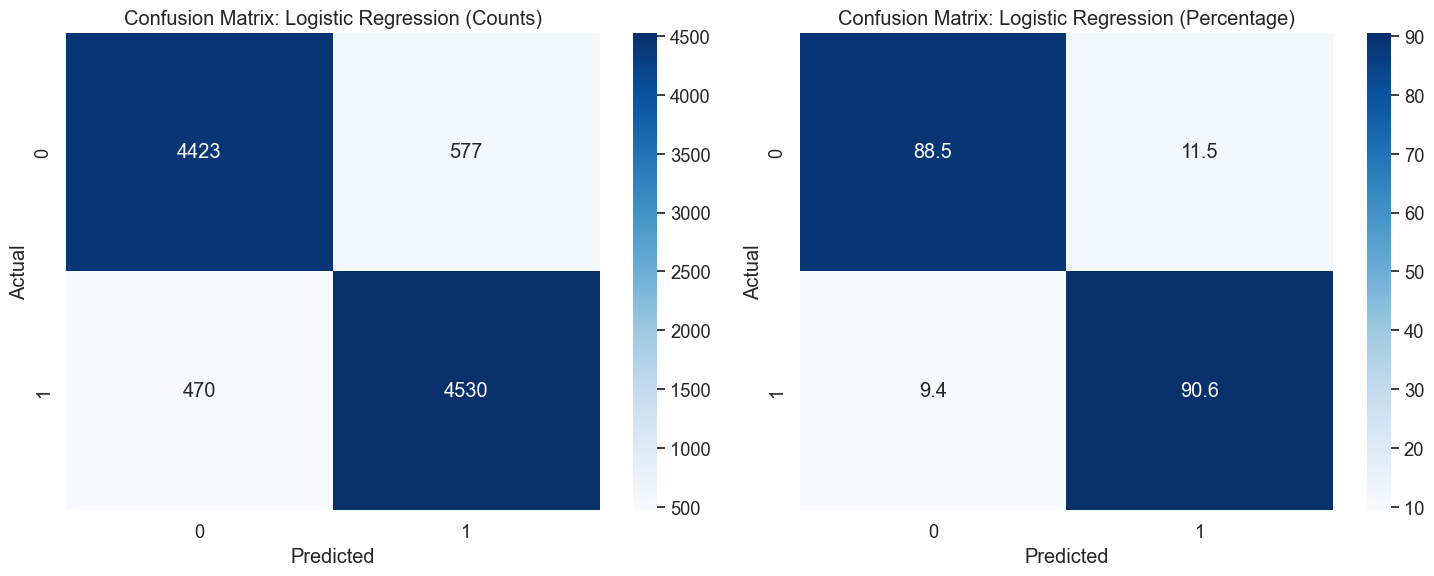

<Figure size 1200x600 with 0 Axes>

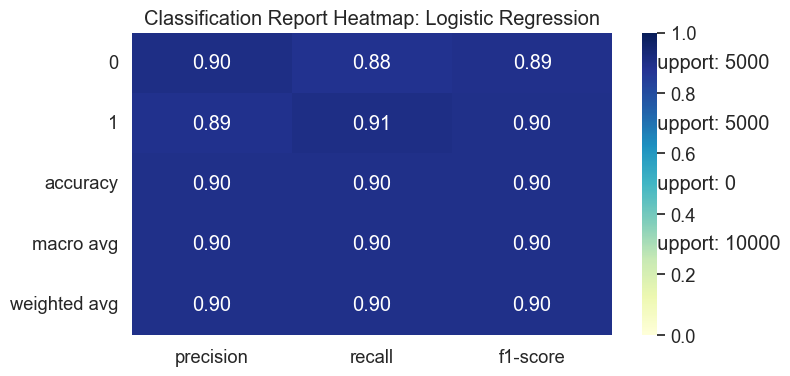

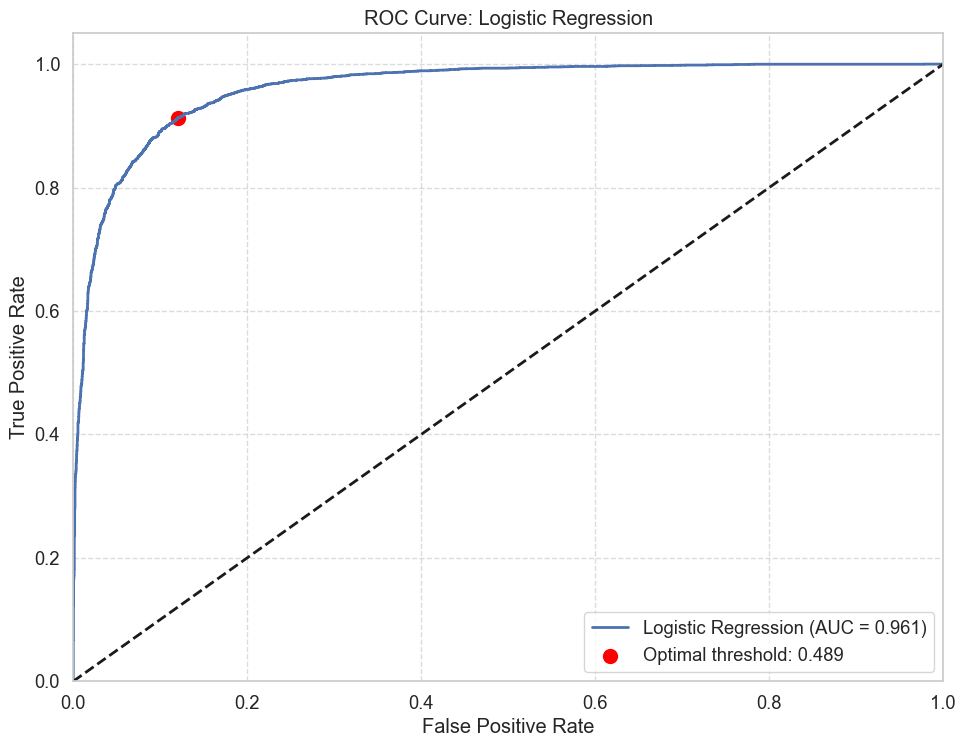

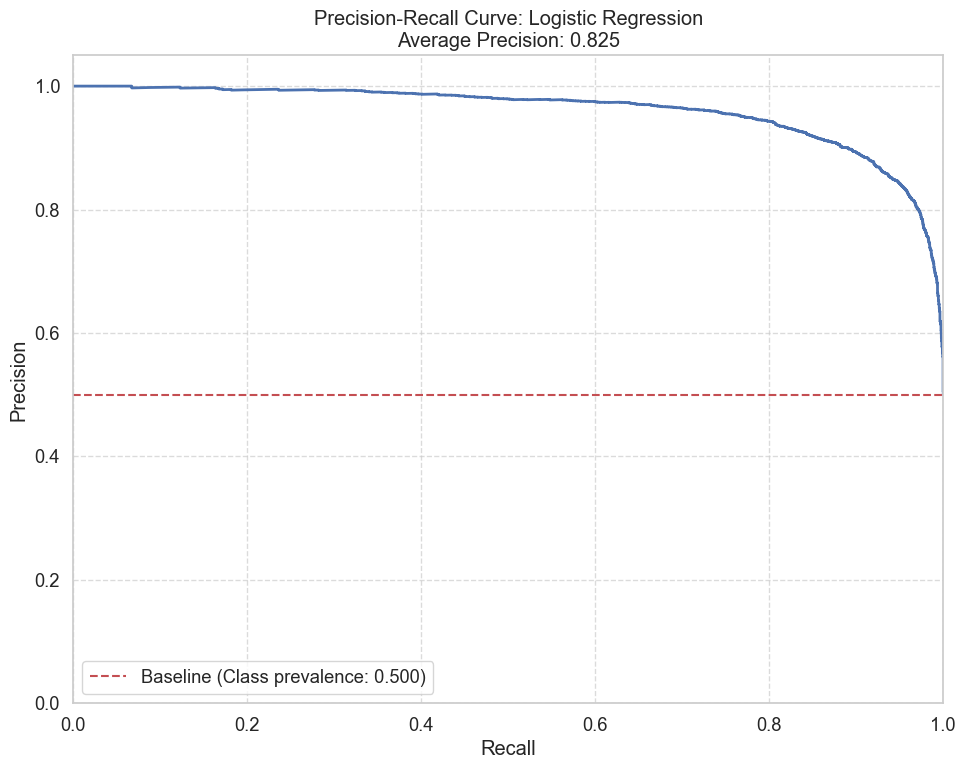

<Figure size 1200x500 with 0 Axes>

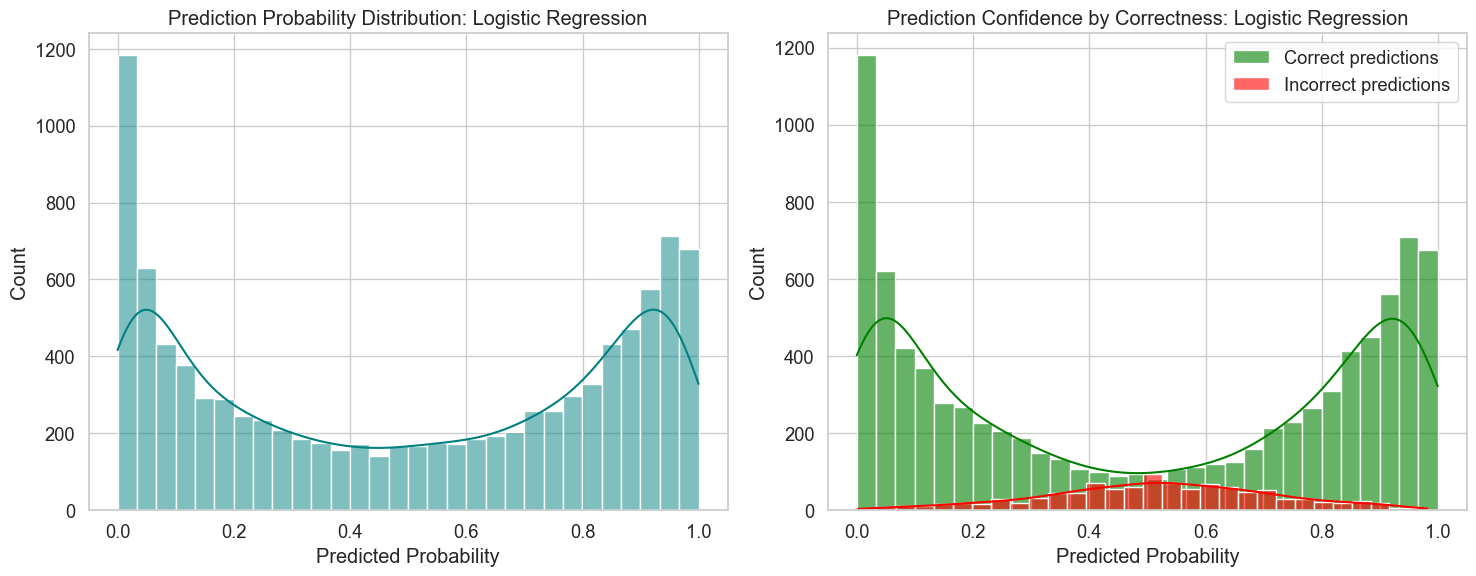


🔍 ERROR ANALYSIS

Top 5 confident misclassifications:

Example 1:
  Text: sleek sexy movie must see upon multiple viewing one truly understand uniqueness film personally enjo...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9817

Example 2:
  Text: major payne film major make life living hell small group boy marine film really lot offer provides s...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9686

Example 3:
  Text: excited hyped watching film promos first came november looked awesome song quite disappointed went w...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9592

Example 4:
  Text: saw winnie heffalump couple day ago nice story based well known character created milne although win...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9583

Example 5:
  Text: story go something like small town girl katie jessica simpson decides visit boyfriend big city arriv...
  True Label: 0
  Predicted Label: 1
  Confidence: 0.9571


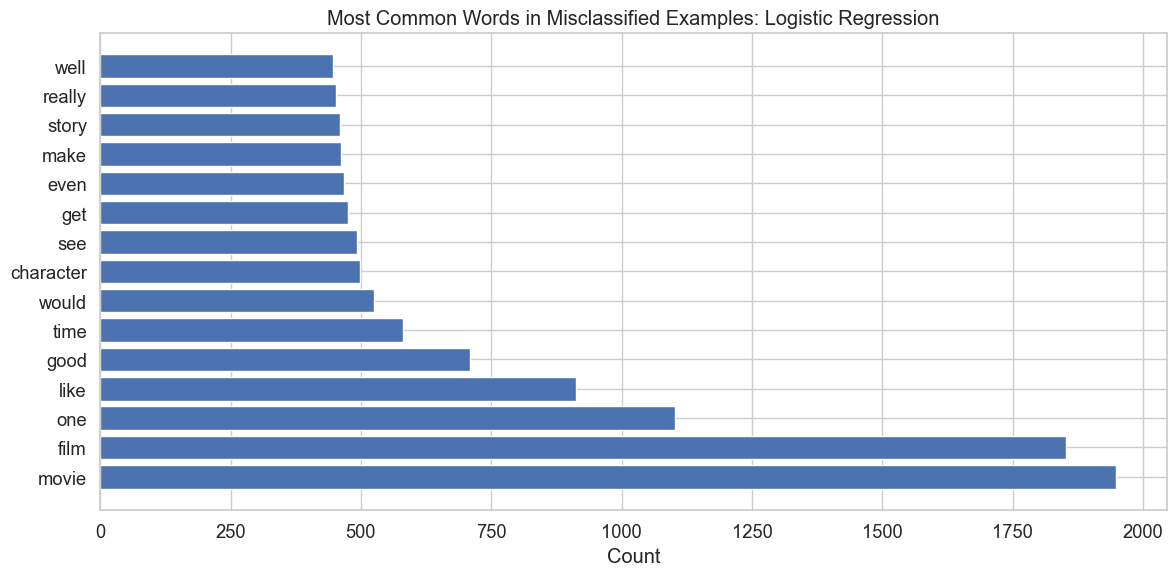

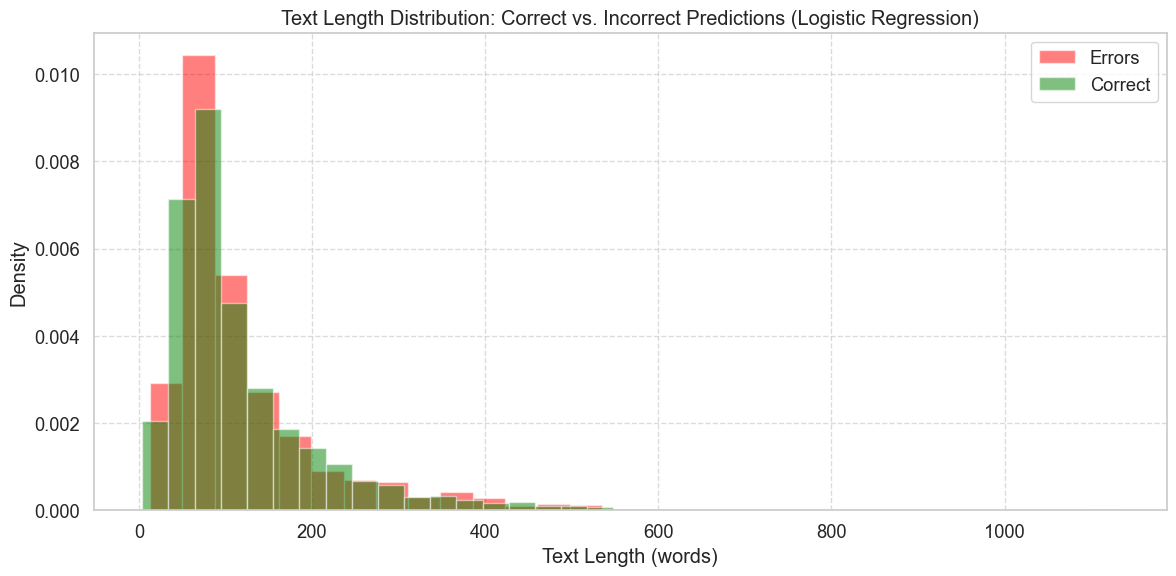

GPU memory before clearing:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 2.98 GB
  Reserved:  3.80 GB


C:\Users\abdul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\__init__.py:1117: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)



GPU memory after clearing:
GPU 0 - NVIDIA GeForce RTX 3050 Ti Laptop GPU:
  Allocated: 2.98 GB
  Reserved:  3.80 GB

Loading and evaluating lstm model


UnboundLocalError: cannot access local variable 'torch' where it is not associated with a value

In [43]:
# Run the load and evaluate function for each model in sequence
# This prevents GPU memory from filling up with multiple models

# Start with a clean GPU
print("Clearing GPU memory before evaluation...")
clear_gpu_memory()

# Store results for comparison
all_results = []

# Evaluate models one at a time
lr_results = load_and_evaluate_model('logistic_regression')
all_results.append(lr_results)

clear_gpu_memory()

lstm_results = load_and_evaluate_model('lstm')
all_results.append(lstm_results)

clear_gpu_memory()

bert_results = load_and_evaluate_model('bert')
all_results.append(bert_results)

clear_gpu_memory()

# Final model comparison
print("\n" + "="*50)
print("📊 MODEL COMPARISON SUMMARY")
print("="*50)

# Create comparison DataFrame
import pandas as pd
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df[['model_name', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'auc', 'prediction_time']]

# Display formatted comparison table
print(comparison_df.set_index('model_name').round(4))